In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv
import copy
import sklearn.linear_model
from sklearn import preprocessing
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
COLOR_TREAT = "#2ecc71"
COLOR_NO_TREAT = "#e74c3c"
import warnings
warnings.filterwarnings('ignore')

# Data exploration of conflicts and agreements
## Naïve analysis of the peace agreement dataset :

The Peace agreements dataset contains a large set of variable (69) defining the type of the agreement signed. We list below a few explanations of the features.

** PAID : ** Peace Agreement ID

**Region : **
The regional variable specifies the regional location of the conflict:
1. Europe: Geographic definition, including the states in the Caucasus. (COW numbers 200–395) 
2. Middle East: Egypt, Iran, Iraq, Israel, Jordan, Kuwait, Lebanon, Syria, Turkey, and the states of the Arabian Peninsula (COW numbers 630–698)
3. Asia: Geographic definition, including Oceania, Australia, and New Zealand, and excluding states in the Middle East. (COW numbers 700–990)
4. Africa: Geographic definition, excluding states in the Middle East (eg. Egypt). (COW numbers 400– 625)
5. Americas: Geographic definition, including states in the Caribbean. (COW numbers 2–165)

**GWNO : ** Gleditsch & Ward System Membership Table, it represents the country code

**CID : ** - Conflict ID

** Ended : ** 1 represents a PA that was terminated, 0 its success.

This dataset contains also some binary features to define the type of the agreement. There are binary features for :
- Behavioral conduct of the warring parties
- Regulation of governmental incompatibility
- Regulation of territorial incompatibility
- Justice issues
- Implementation issues
- Termination Variables : which corresponds to the evaluation of the agreement
- Type of process : is a full or partial peace agreement process

In [243]:
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
cols = ['bwdID', 'pa_comment', 'c_sign', 'c_3rd', 'c_duration', 'Reaffirm ID', 'Comment', 'txt', 
        'Link to fulltext agreement', 'ProcID', 'Frame', 'All', 'Counter' , 'Duration']
pa.drop(columns=cols, inplace=True)

In [244]:
regiondic = {
    1:'Europe',
    2:'Middle East',
    3:'Asia',
    4:'Africa',
    5:'Americas'
}
pa['Region'].replace(regiondic , inplace = True)

## Distribution of the agreements by region

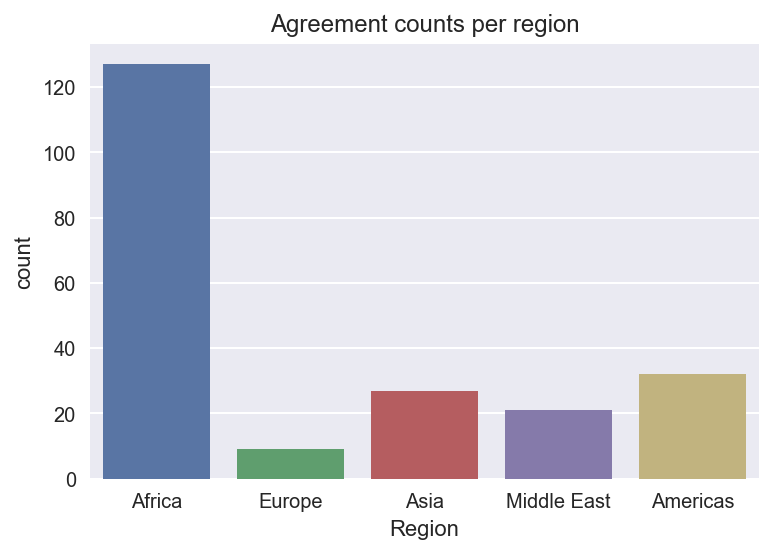

In [245]:
sns.countplot(x='Region', data=pa)
plt.title('Agreement counts per region')
plt.xlabel('Region');

This plot shows the number of peace agreements per region. We can see that most agreements concern Africa.

## Distribution of agreements by year

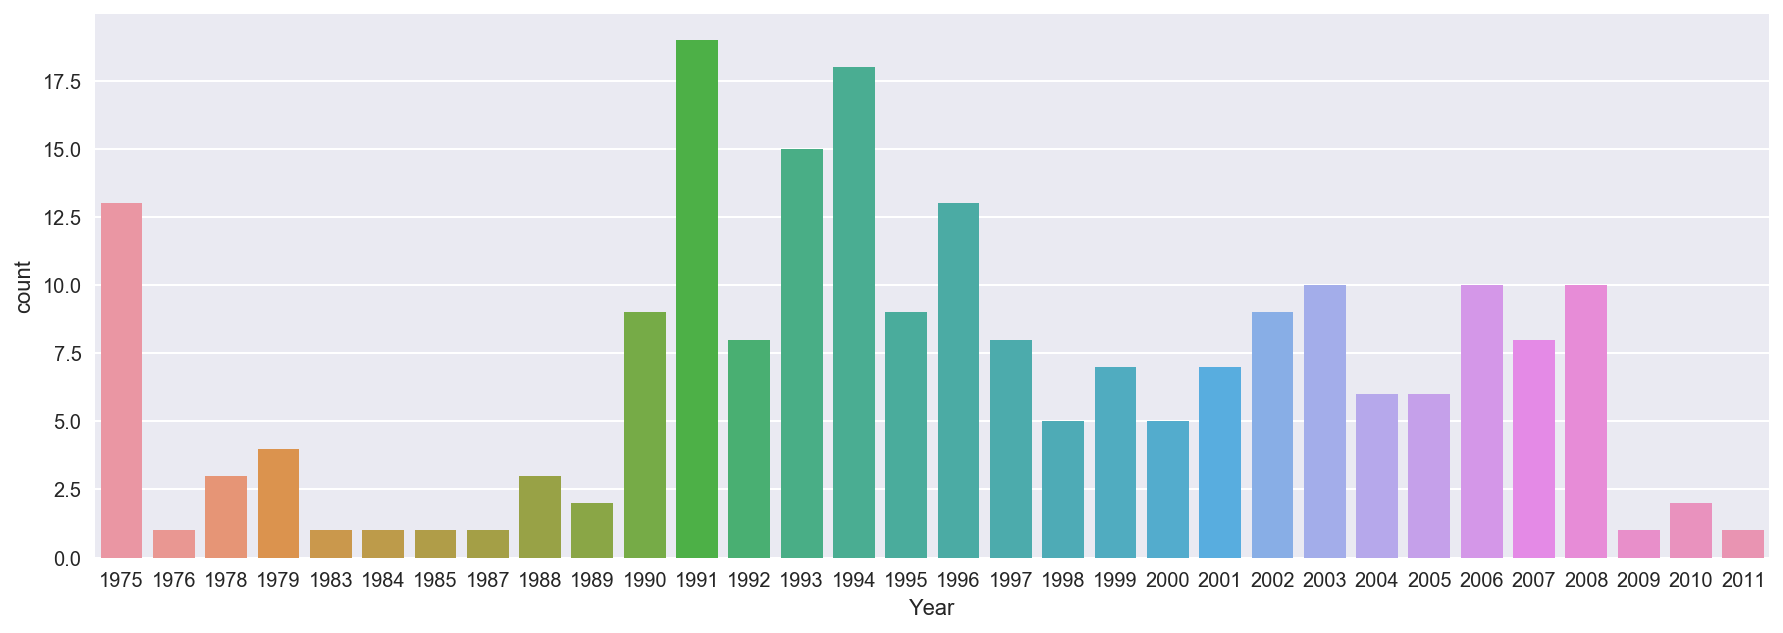

In [246]:
plt.figure(figsize=(15,5))
sns.countplot(x='Year', data=pa)

1991 is the year where most peace agreements were signed. There has been two periods with a low amount of peace agreement, from 1983 to 1987 and from 2009 to 2011.
## UN involvment in the Peace agrements
First create a new dataset with only the agreements where the UN took part then, create a new column in the pa dataset (1 if the agreement was signed by the UN, else).



In [247]:
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('UN')]
pa["UN"] = [1 if ele in pa_UN.CID else 0 for ele in pa.CID]

In [248]:
#Let's check how many conflicts did the UN solved
pa.groupby("UN").count()

,PAID,Region,GWNO,CID,Name,DyadName,actorId,Inc,pa_name,Year,...,Co_impl,DyVi05,CoVi01,noconf,termdur,noconf11,inclusive,no_dyad,pa_type,Out_iss
UN,,,,,,,,,,,,,,,,,,,,,
0,181,181,181,181,181,181,181,181,181,181,...,181,181,181,181,181,181,181,181,181,181
1,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35


In [249]:
to_be_categorical = ['termdur' , 'noconf11' , 'CoVi01' ,'DyVi05' ]
for categ in to_be_categorical:
    pa[categ] = pd.Categorical(pa[categ] , pa[categ].unique())

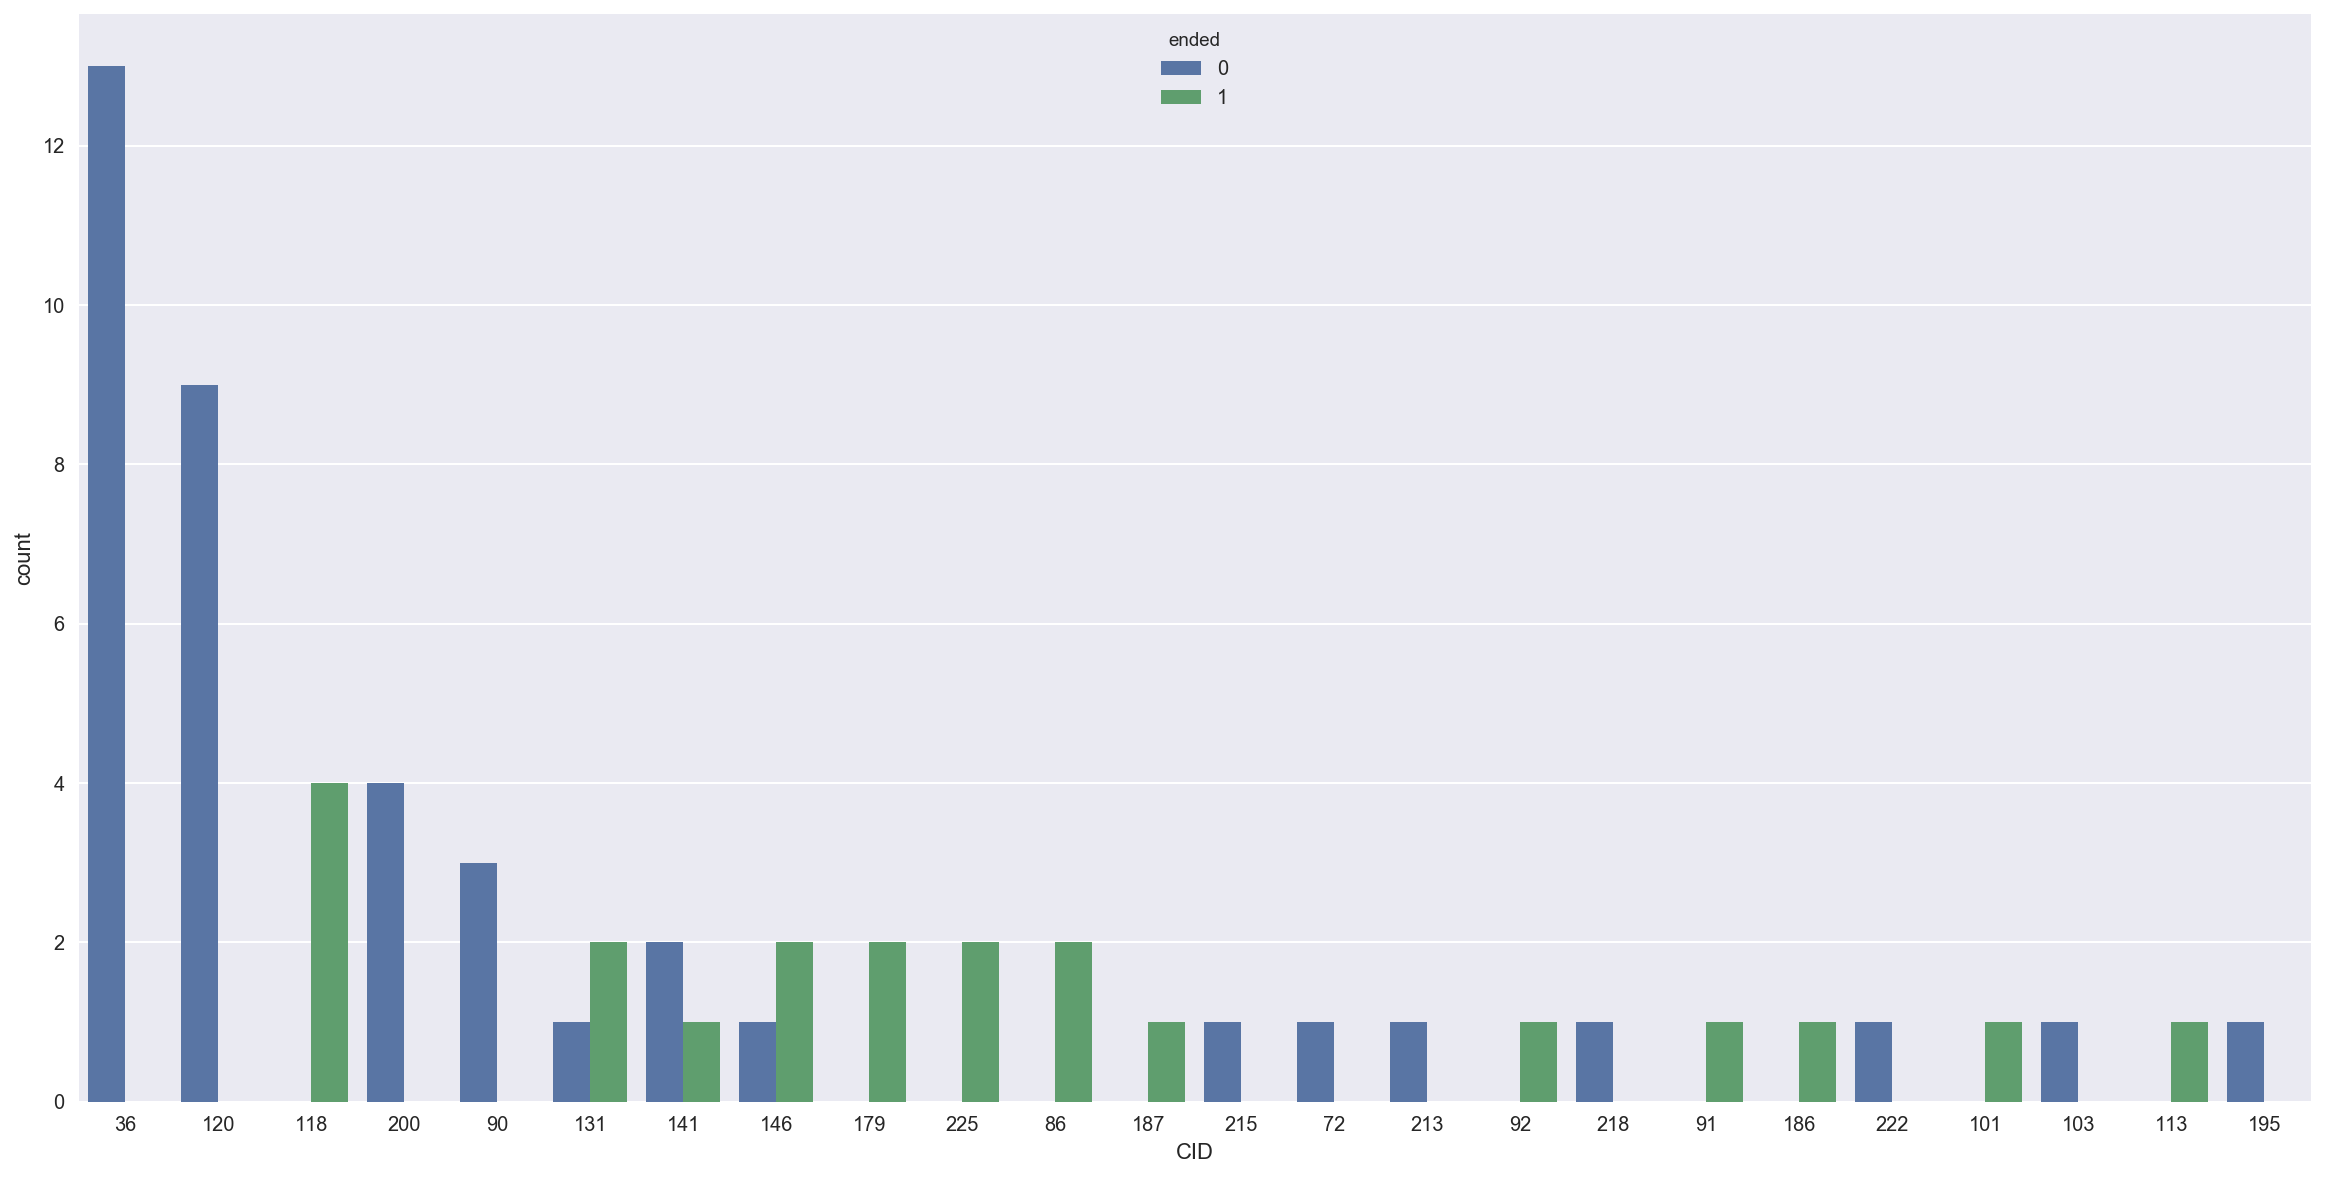

In [250]:
plt.figure(figsize=(20,10))
sns.countplot(x='CID', data= pa_UN, hue='ended', order=pa_UN.CID.value_counts().index)

Out of the 216 agreements, The United Nations were involved in 35. We detect three groups of conflicts out of 35 concerned. 10 conflicts were not solved with the agreements, 3 conflicts were solved in three agrements with the one or two agreements that terminated. 11 conflicts had all of their respective agreements still valid as of 2011.


## Analysis of the Conflict ID variable

In [251]:
print('Number of conflicts treated in this dataset : %s' %(len(pa.CID.unique())))

Number of conflicts treated in this dataset : 60


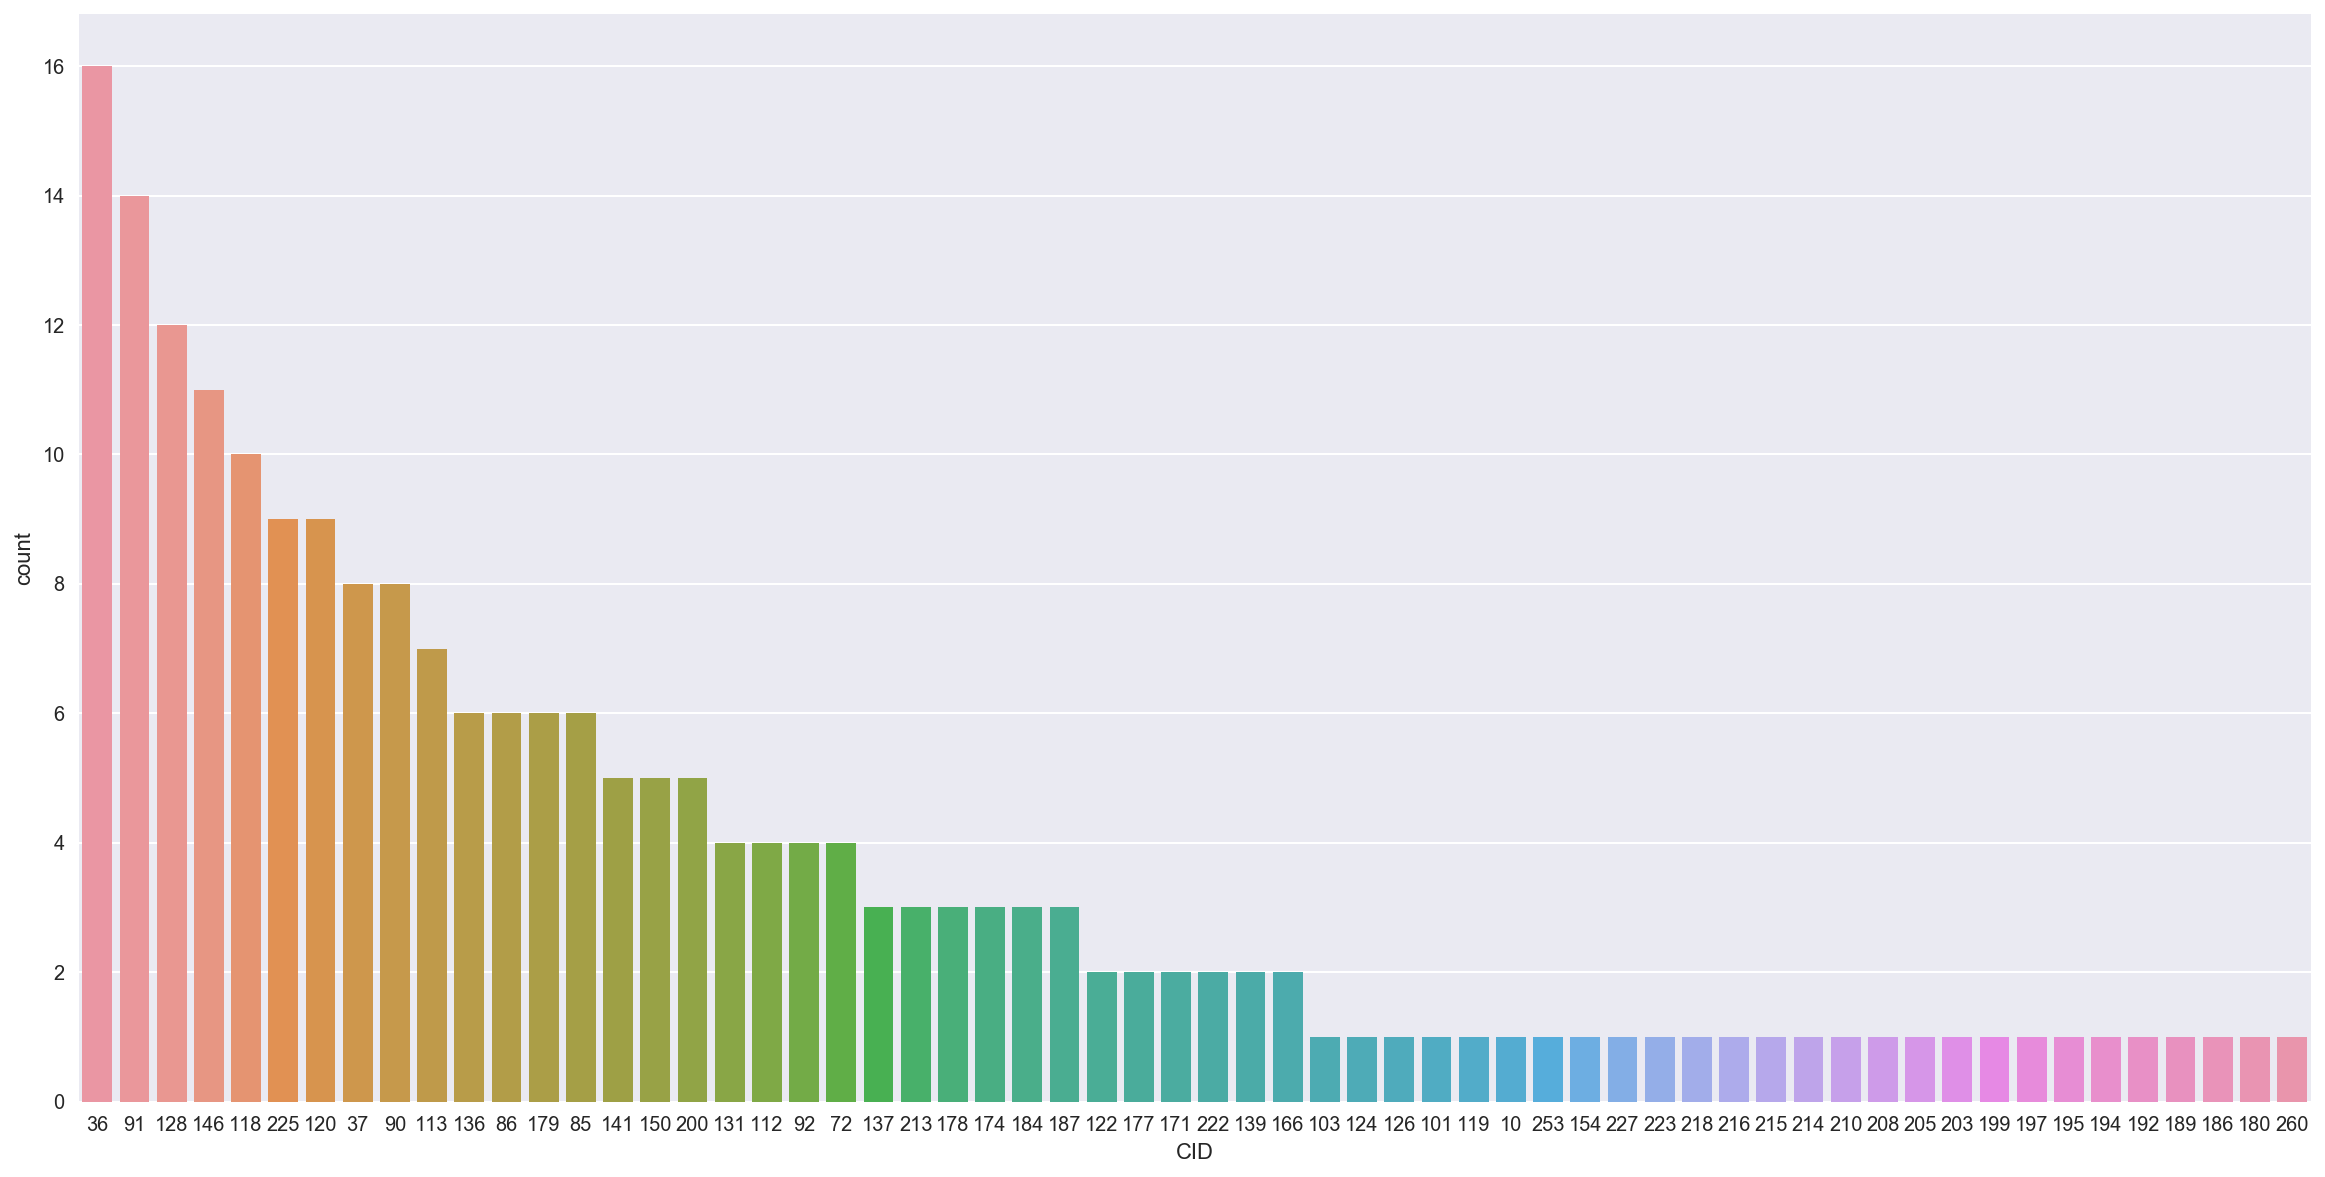

In [252]:
plt.figure(figsize=(20,10))
sns.countplot(x='CID', data=pa, order=pa.CID.value_counts().index)

This plot shows that approximtely half of the conflicts were treated with one agreement. We wil split the rest of the exploration into two groups, the ones solved in one agreements and one grouping all the others.

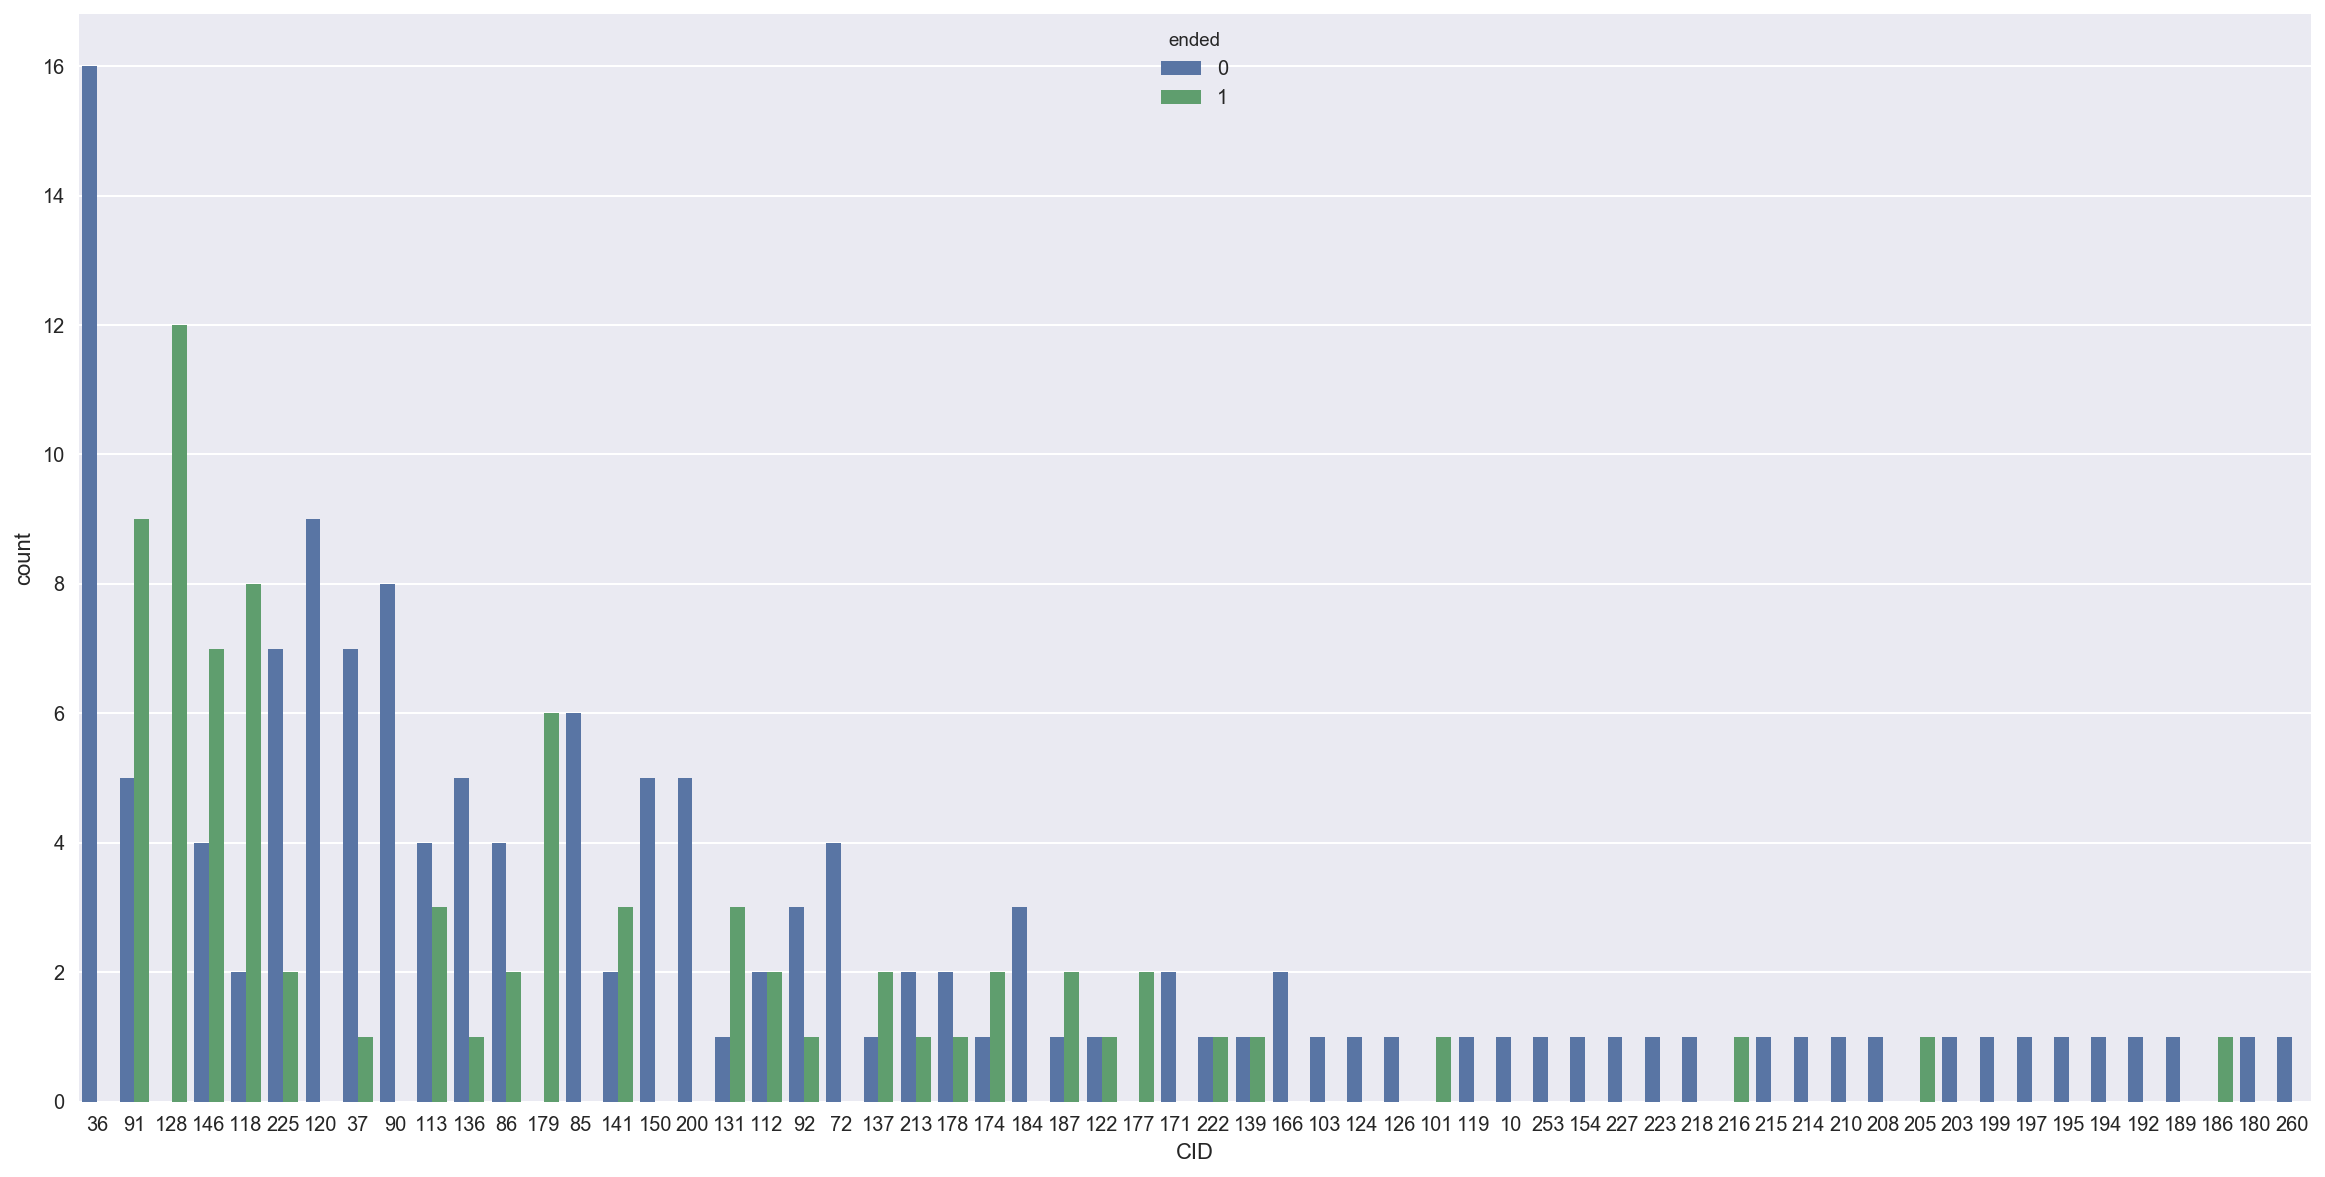

In [253]:
plt.figure(figsize=(20,10))
sns.countplot(x='CID', data= pa, hue='ended', order=pa.CID.value_counts().index)

Most conflicts ended with agreements that are still valid today. 
All agreements of the conflicts (179, 128, 177, 101, 216 205, 185) were terminated which means that none of them worked. 


## Analysis of the conflicts that could not be ended by the peace agreements

In [254]:
pa_128 = pa.loc[pa['CID'] == 128]
#pa_128.to_csv('Unsolved_CID128.csv')

**Conflict 128 :**

Conflict between Iran and Iraq. Each of the 12 agreements were signed in 1975. Despite the first agreements, that was signed by The Shah of Iran and Saddam Hussein, all of them were signed by the same two representatives of Iran and Iraq, respectively by ABBAS-ALI KHALATBARY, Minister for Foreign Affairs of Iran and SAADOUN HAMADI, Minister for Foreign Affairs of Iraq. 
These agreements that were active in 1975, were than terminated between 1975 and 1980 until they were reactivated. Although the agreements were reactivated in 1980. Conflicts between Iran and Iraq did not stop in 1980, hence we can consider those agrrements as failures.

In [255]:
pa_179 = pa.loc[pa['CID'] == 179]
#pa_179.to_csv('Unsolved_CID179.csv')

**Conflict 179 :**

This conflict concerned the Government of the Republic of Rwanda and the Rwandese Patriotic Front. The six agreements were signed between 1992 and 1993. The incompatibility is governmental.
The five first agreements were signed to provide partial peace and the last one in august 1993 was supposed to prvide full peace to the region. None of the agreements provided for the holding of national talks to solve incompatibility and for the integration of rebels into civil service.
In April 1994, a genocide broke out and the peace agreements were never fully implemented.

**Conflict 101 : **

This conflict originated from a governmental incompatibility between South Africa and Namibia. The agreement was signed in 1978 and lasted two months. The agreement contained provisions for political incompatibilities leading to independence for Namibia, justice provisions with the return of refugees and release of political prisoners and behavior regulations such as (ceasefire, withdrawal of foreign forces and demobilisation of local armies).
 
**Conflict 216 : **

Government of Guinea Bissau - Military Junta for the Consolidation of Democracy, Peace and Justice. Incompatibility 2, The peace agreement lasted for 6 months.

** Conflict 205 : **

The agreement covered indigenous rights and culture and strengthened the position of the indigenous people in Mexico. incompatibility 2. The accord was never implemented and thus further peace talks that were planned in September the same year were suspended by EZLN. No exact date for the ending of the peace accord has been found.

All of the conflicts that were treated by only one agreement and had terminated originated from governmental imcompabilities. 

In [256]:
pa.loc[pa['CID'] == 186]
#pa.iloc[77,:].to_csv('Unsolved_CID101.csv')
#pa_179.to_csv('Unsolved_CID179.csv')

,PAID,Region,GWNO,CID,Name,DyadName,actorId,Inc,pa_name,Year,...,DyVi05,CoVi01,noconf,termdur,noconf11,inclusive,no_dyad,pa_type,Out_iss,UN
127,411993070301,Americas,41,186,Haiti: government,Government of Haiti - Military faction (Forces...,"41, 1625",2,The Governor's Island agreement,1993,...,0,0,1,2,0,2,1,3,5,0


## Analyze conflicts solved in one agreements that are still valid as of 2011


In [257]:
idx = pa['CID'].value_counts()
idx_1 = idx[idx.values == 1]
idx_1.index

Int64Index([103, 124, 126, 101, 119,  10, 253, 154, 227, 223, 218, 216, 215,
            214, 210, 208, 205, 203, 199, 197, 195, 194, 192, 189, 186, 180,
            260],
           dtype='int64')

In [258]:
indx_1_ended = []
for ind in idx_1.index:
    #print(ind)
    a = pa.ended[pa['CID'] == ind]
    if a.iloc[0] == 0: # ended is the column 17 
        indx_1_ended.append(a.index)
    
pa_one = pa.iloc[np.array(indx_1_ended)[:,0], :]
pa_one.head(2)

,PAID,Region,GWNO,CID,Name,DyadName,actorId,Inc,pa_name,Year,...,DyVi05,CoVi01,noconf,termdur,noconf11,inclusive,no_dyad,pa_type,Out_iss,UN
196,8111991102301,Asia,811,103,Cambodia (Kampuchea): government,"Government of Cambodia (Kampuchea) - KR, Gover...","811, 1112, 1114, 1115",2,Agreement on a Comprehensive Political Settlem...,1991,...,1,0,0,-99,-99,1,3,1,0,0
62,67868019790330,Middle East,"678, 680",124,North Yemen - South Yemen,Government of Yemen (North Yemen) - Government...,"678, 680",3,Kuwait agreement,1979,...,0,1,0,-99,1,1,1,2,2,0


**Let's analyse the different combination of behavioral provisions that were taken and led to the success of the these agreements.**

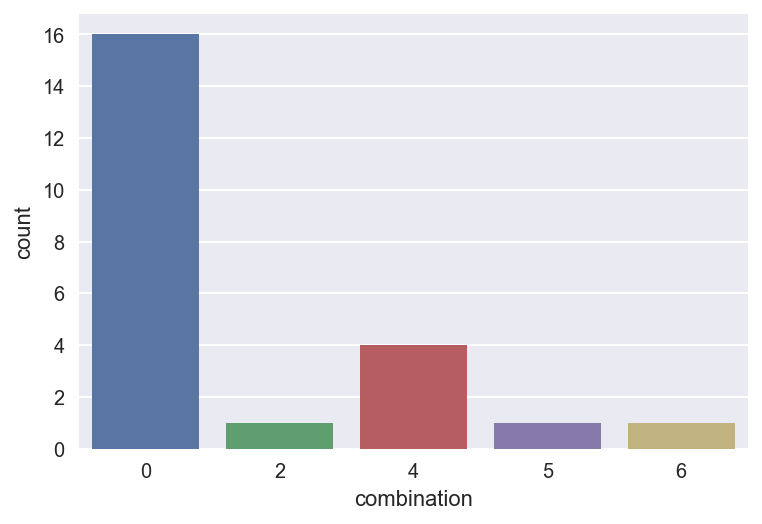

In [261]:
pa_1behavior = pa_one.iloc[:, 20:25]
pa_1behavior['combination'] = pa_1behavior.apply(whatcombi, axis=1)
sns.countplot(x='combination', data=pa_1behavior)

8 successfull agreements established peace in providing for a ceasefire. 3 provided for the withdrawal of foreign forces and 3 others provided for a ceasefire, the integration of rebels into the army and the disarmement of the warring parties.

**Let's analyse the different combination of governmental and territorial incompatibility provisions that were taken and led to the success of the these agreements.**

Because we merged the incompabilities, the number of possible combinations to analyse equals to $2^{18}$ hence we saved the results to save computation time.

In [262]:
#pa_1incompatibility = pa.iloc[:, 25:43]
#pa_1incompatibility['combination'] = pa_1incompatibility.apply(whatcombi, axis=1)
#pa_1incompatibility.to_csv('pa_1PA_success.csv')
pa_1incompatibility = pd.read_csv('pa_1PA_success.csv')
#pa_1incompatibility['inc'] = pa.iloc[np.array(indx_1_ended)[:,0], 8]

In [263]:
a = copy.deepcopy(pa_1incompatibility.groupby('combination').count().pp)
a.sort_values(ascending=False, inplace=True)

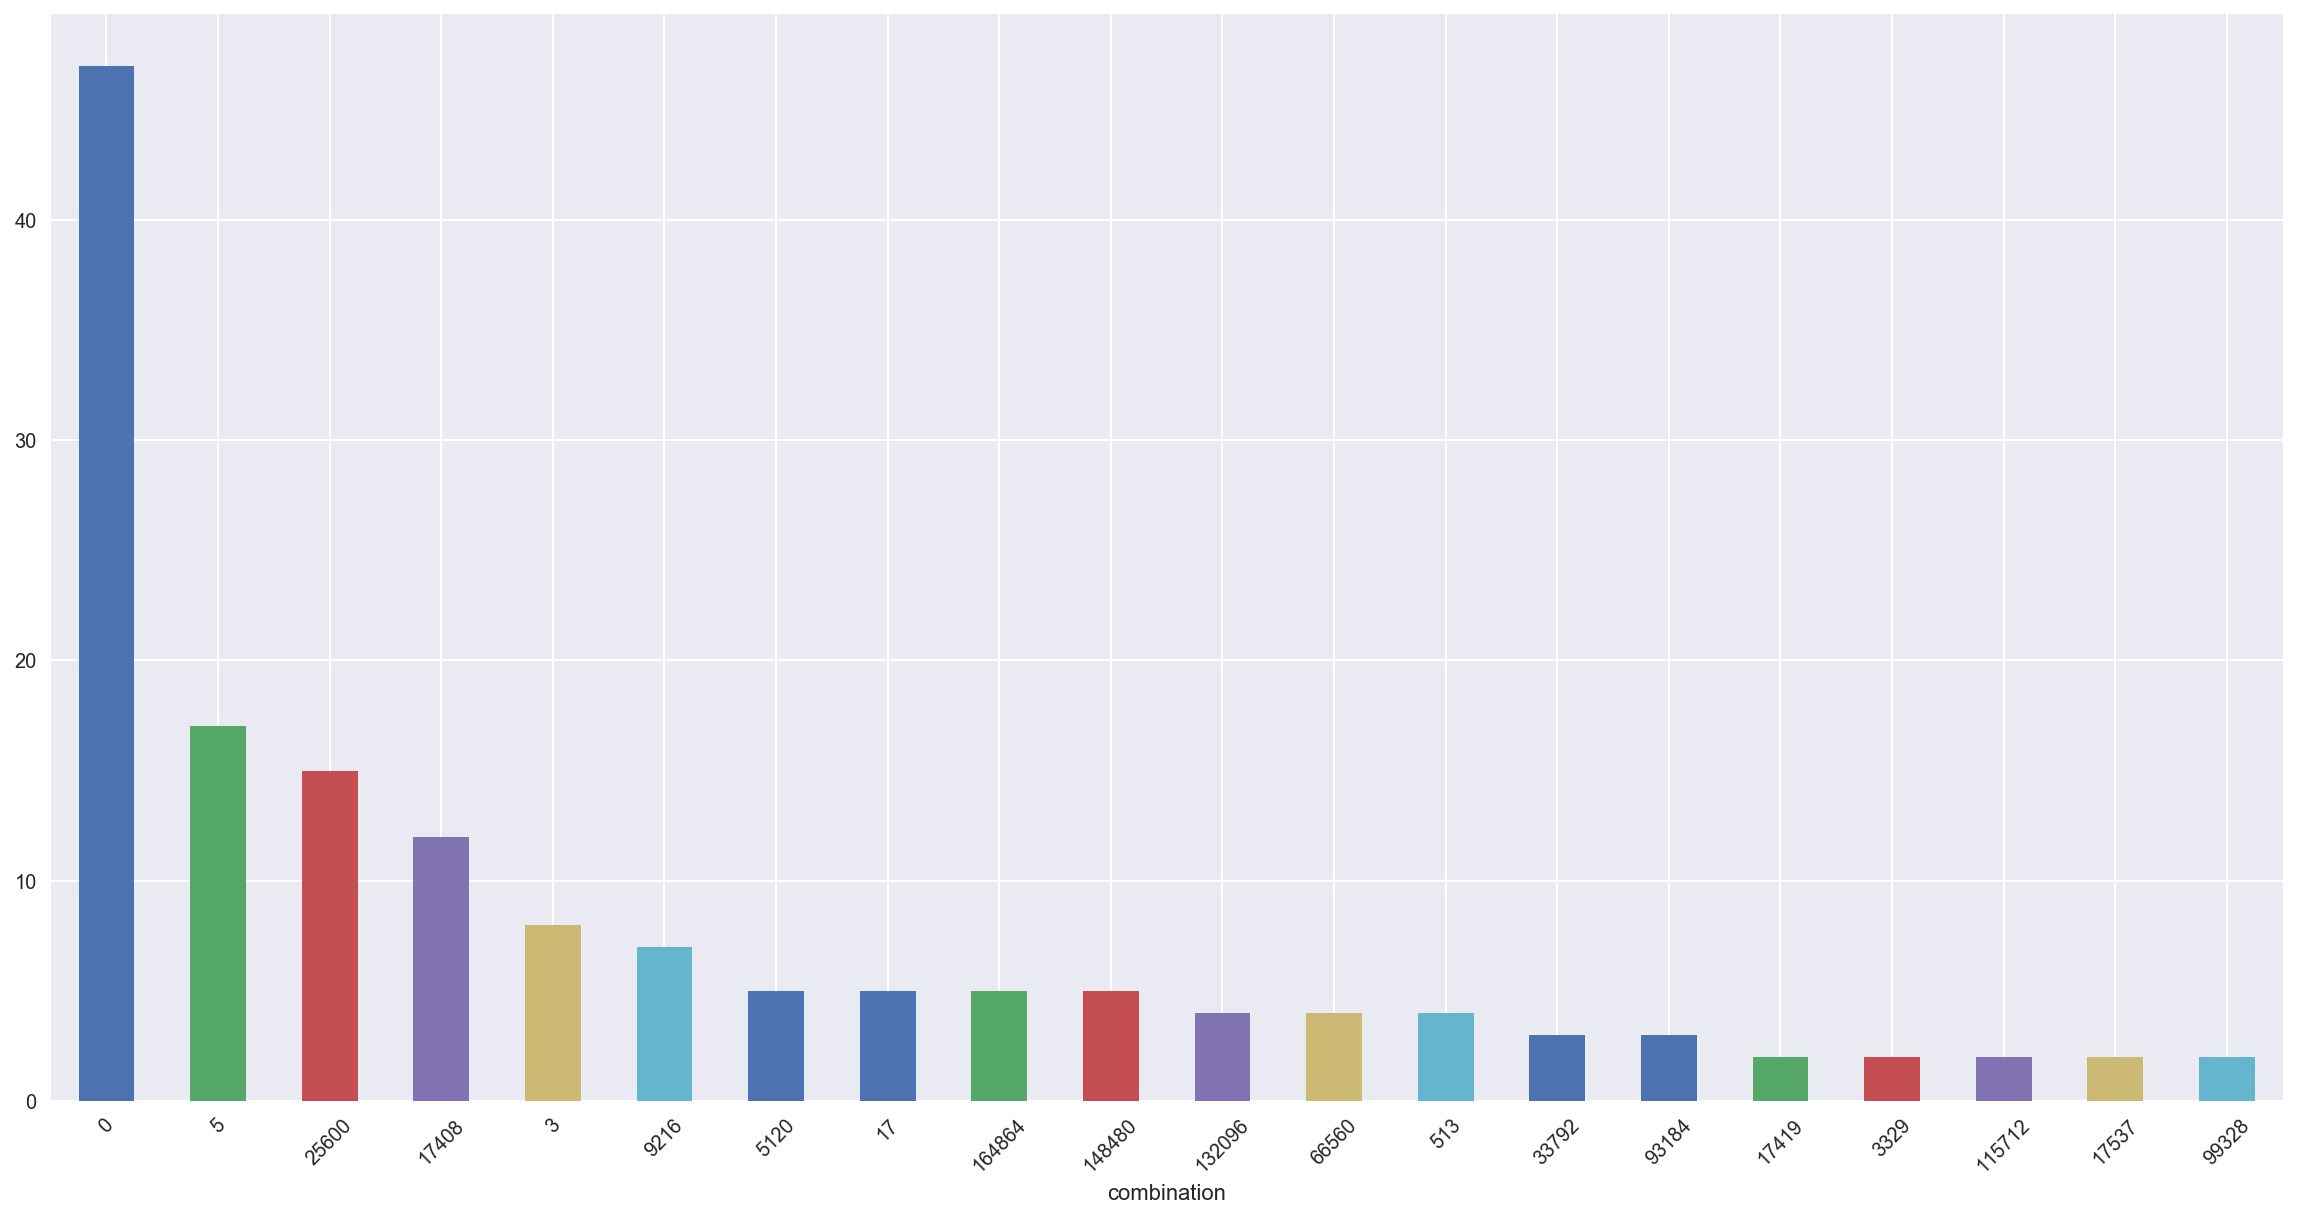

In [264]:
plt.figure(figsize=(20,10))
a[:20].plot('bar', rot=45)
#sns.countplot(x='combination', data=pa_1incompatibility, order=pa_1incompatibility.combination.value_counts().index)

In [265]:
lst = [list(i) for i in itertools.product([0, 1], repeat=18)]
print(lst[5])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]


Most of the time, no incompatibility provisions is set in those successful agreements. The abscence of incompatibility provisions might be an insight to explain their success as they do not have high expectations. The second most recurrent agreements treat territorial incompatibilities and grant the disputed region local governance. Governmental incompatibilities are mostly solved with provisions for elections and an interim government.

## Whatcombi :  This function returns corresponding combination to a pandas row dataframe
This function is to be used for each type of provisions.

In [286]:
def whatcombi(pa):
    # returns the corresponding combination number of the dataset
    # set : n and rerun box in fct of the number of binary features to be analyzed
    n = 4
    # Create 2^n vectors of size n representing a combination
    lst = [list(i) for i in itertools.product([0, 1], repeat=n)]
    for i in range(len(lst)):
        a = pa == lst[i]
        # if all values in a are true, it is the good combination
        if all(x for x in a.values):
            return(i)

## Analysis of the agreements termination consistency in the variables :

- **ended** 
    - 0) if the agreements still holds
    - 1) if the agreement terminated
    
- **DyVi05** 
    - 1) the dyad violence restarted or continued
    - 0) the violence ended in this dyad
    - -99) Not applicable, agreement signed previous year

In [266]:
pa_result = pa.loc[:, ['ended', 'DyVi05']]
pa_result.head()

,ended,DyVi05
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0


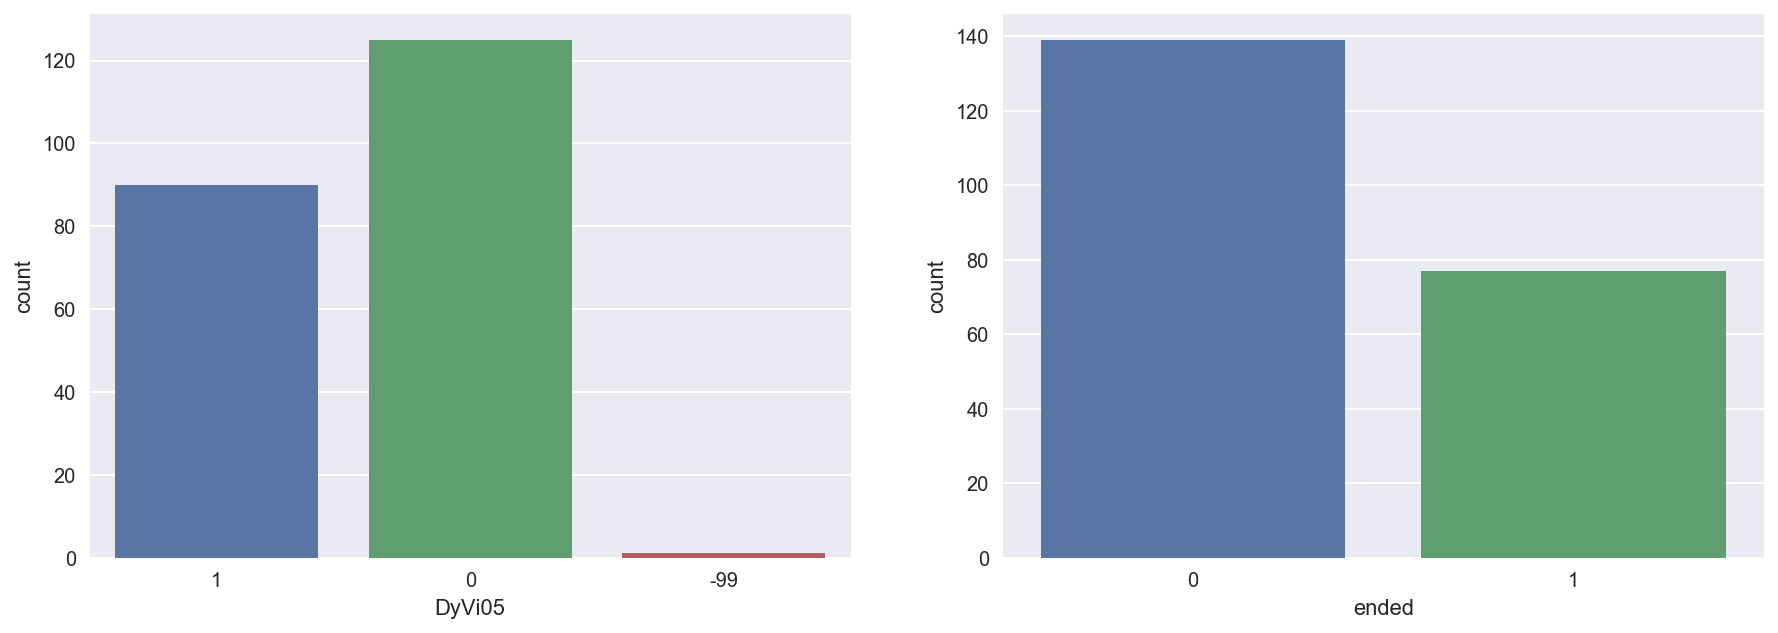

In [267]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='DyVi05', data=pa)
plt.subplot(122)
sns.countplot(x='ended', data=pa)

Thoses plots show that approximately 140 agreements ended there corresponding conflict. This information should be crossed with the number of conflicts treated in this dataset as there are only 60 unique conflicts.

In [269]:
pa_result['combination'] = pa_result.apply(whatcombi, axis=1)

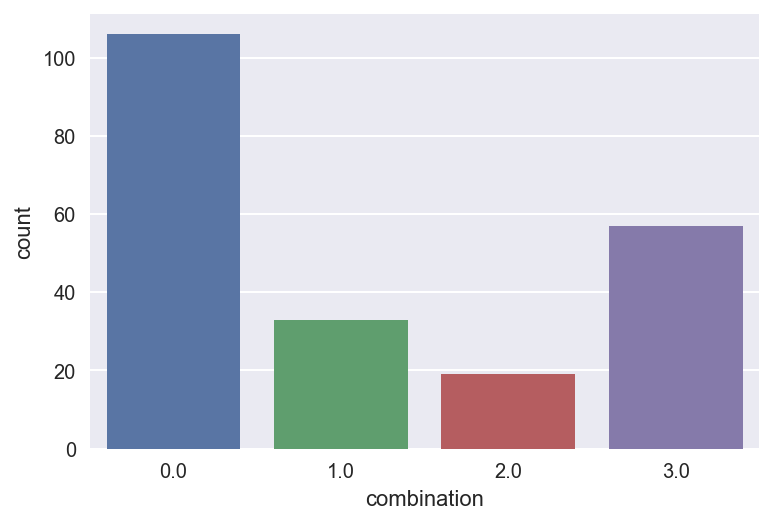

In [270]:
sns.countplot(x='combination', data=pa_result)

Approximately 160 out of 216 (74%) agreements have the same values for the *ended* and *DyVi05* variables. Hence we can say that those variables are consistent.

## Behaviour variables analysis

In [272]:
pa_behavior = pa.iloc[:, 14:18]
# how to analyze a set of binary features ?
pa_behavior.head()
#sns.pairplot(pa_behavior)

,cease,Intarmy,DDR,Withd
0,0,0,0,0
1,1,0,1,0
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0


In [273]:
# run only once
pa_behavior['combination'] = pa_behavior.apply(whatcombi, axis=1)

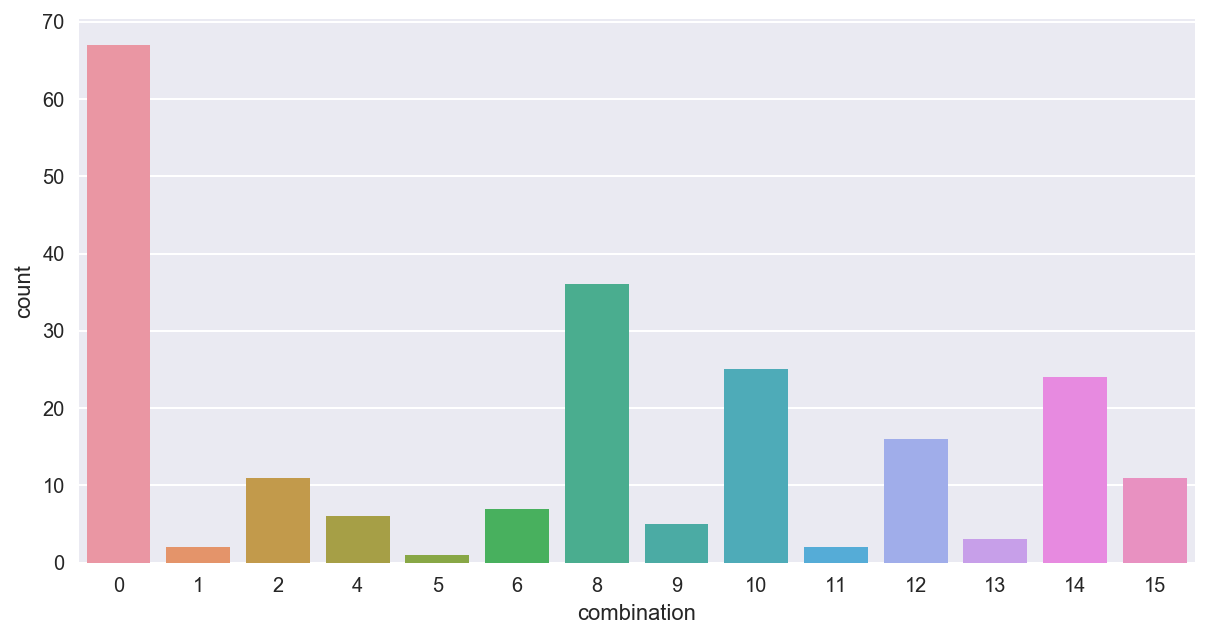

In [274]:
plt.figure(figsize=(10,5))
sns.countplot(x='combination', data=pa_behavior)

In [275]:
lst = [list(i) for i in itertools.product([0, 1], repeat=4)]
print(lst[14])

[1, 1, 1, 0]


1. Most agreements do not treat behavioral instructions
2. The second most recurrent combination concerns agreements that provided a ceasefire
3. third most recurrent :  ceasefire, Disarmement of foreign forces
4. fourth : ceasefire, integration in national army, disarmement of warring parties

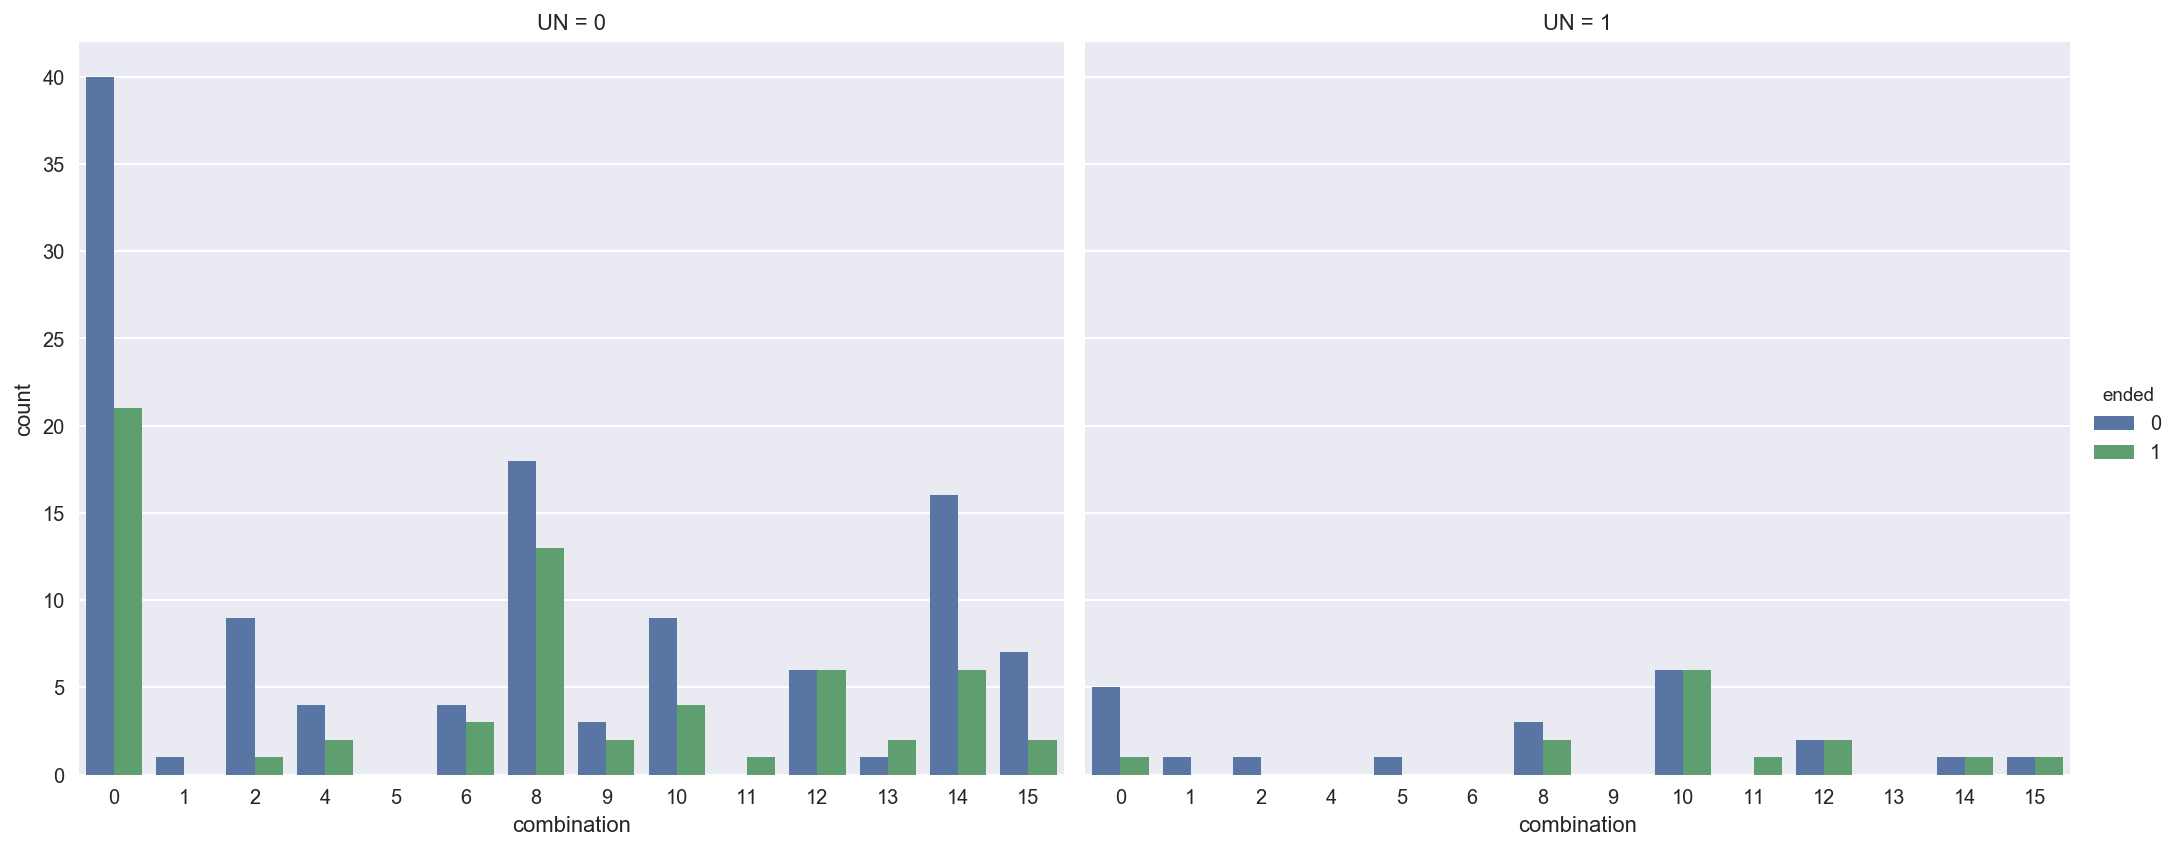

In [276]:
pa_behavior['ended'] = pa['ended']
pa_behavior['UN'] = pa['UN']
sns.factorplot(x='combination', data= pa_behavior, hue='ended', col='UN', kind='count', size=6, aspect = 1.2);

There are no much difference in agreements that terminate or not. However Two kinds of agreements were never terminated. The ones which provided for the creation of a new national army or the integration of rebels into the army and the withdrawal of foreign forces. No much difference can be established between UN agreements and the others considering the small amount of data available.

## Incompatibility variables analysis
### Government incompatibilities
Run the whatcombi box for n = 7 which leads to $2^7$ possible combinations

In [277]:
pa_incompatibility_gov = pa.iloc[:, 19:26]
pa_incompatibility_gov.head()

,pp,Intgov,Intciv,Elections,Interrim,Natalks,Shagov
0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0


In [ ]:
pa_incompatibility_gov['combination'] = pa_incompatibility_gov.apply(whatcombi, axis=1)

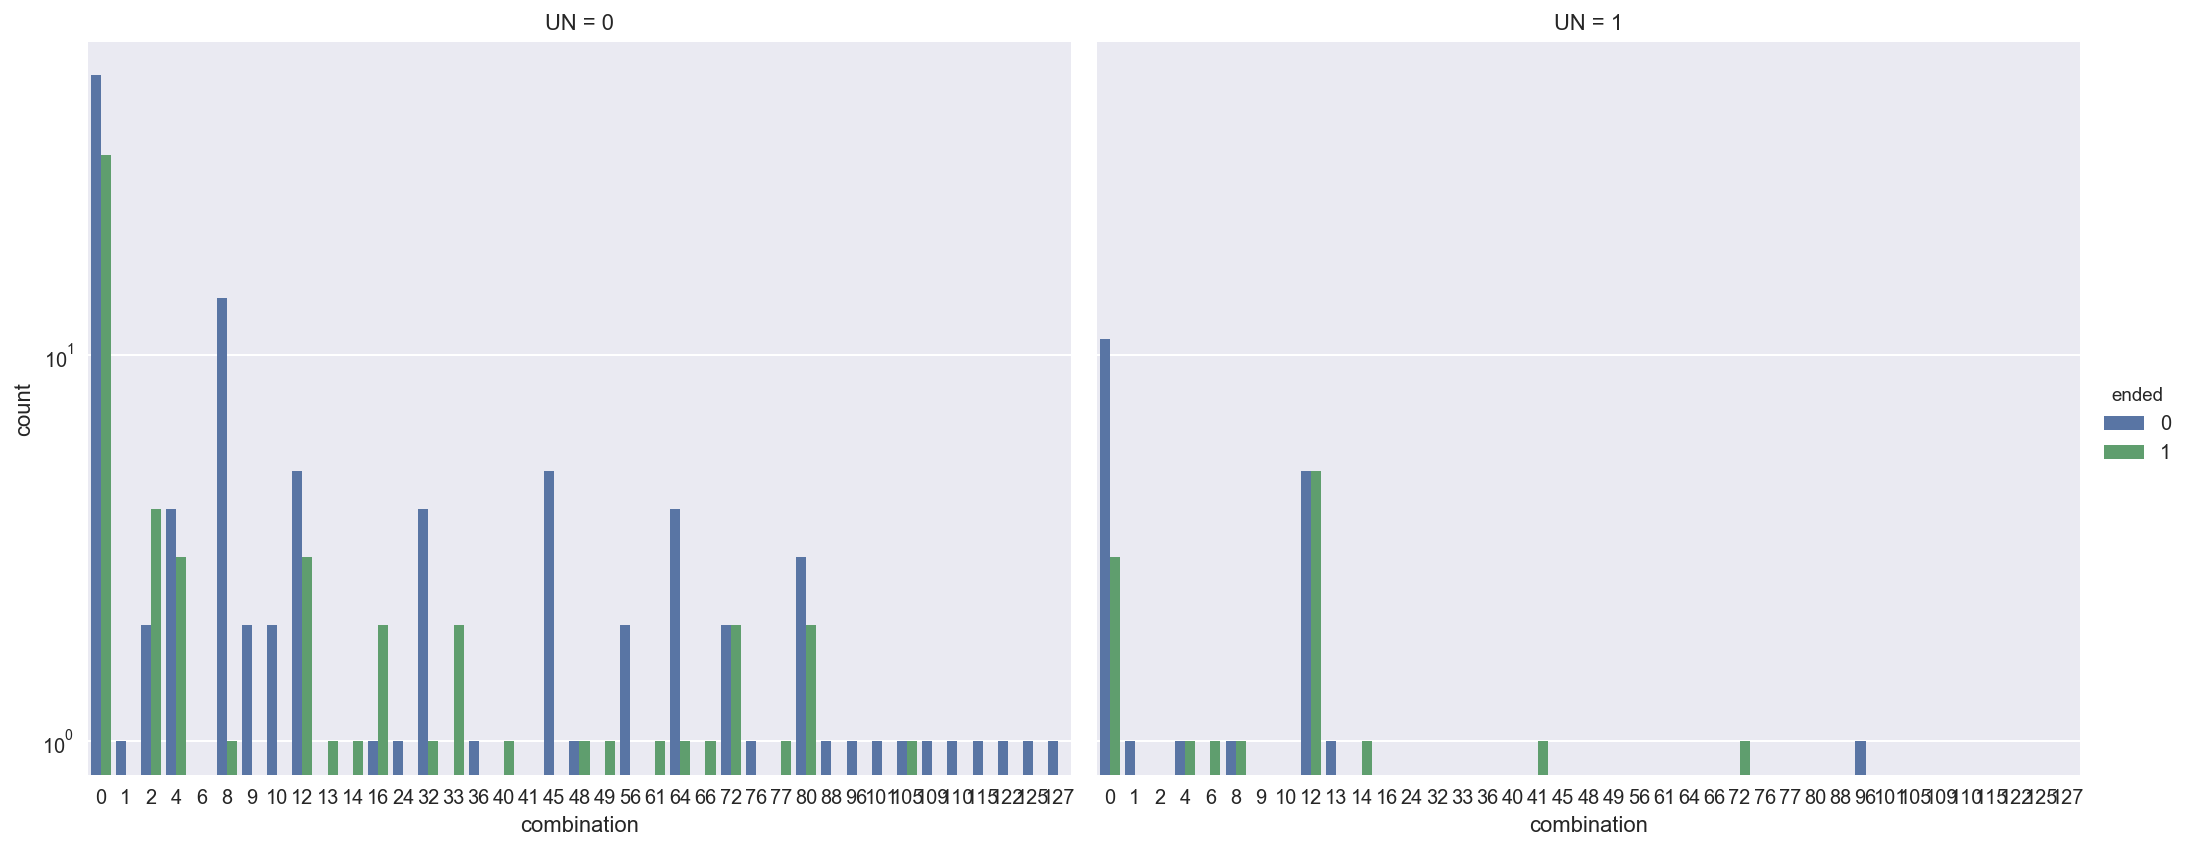

In [280]:
pa_incompatibility_gov['UN'] = pa["UN"]
pa_incompatibility_gov['ended'] = pa['ended']
sns.factorplot(x='combination', data=pa_incompatibility_gov, hue='ended', col='UN', kind='count', size=6, aspect = 1.2)
plt.yscale('log')

While most agreements do not deal with governmental incompatibilities, the ones that do mostly provide for elections and electoral reforms for rebel integration into the interim government.

The main difference that can be observed between UN agreements and non UN agreements is that the UN agreements usually provide provisions for an interim government and elections while non UN agreements msotly only provide provisions for an election.

The *Pol_prov* feature could be used to generalize the inclusion of political provisions in the agreement

### Territorial incompatibilities
run whatcombi box with n = 9

In [281]:
pa_incompatibility_ter = pa.iloc[:, 27:36]
pa_incompatibility_ter.head()

,Aut,Fed,Ind,Ref,Shaloc,Regdev,Cul,Demarcation,Locgov
0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0
4,1,0,0,1,0,0,1,0,0


In [284]:
pa_incompatibility_ter['combination'] = pa_incompatibility_ter.apply(whatcombi, axis=1)

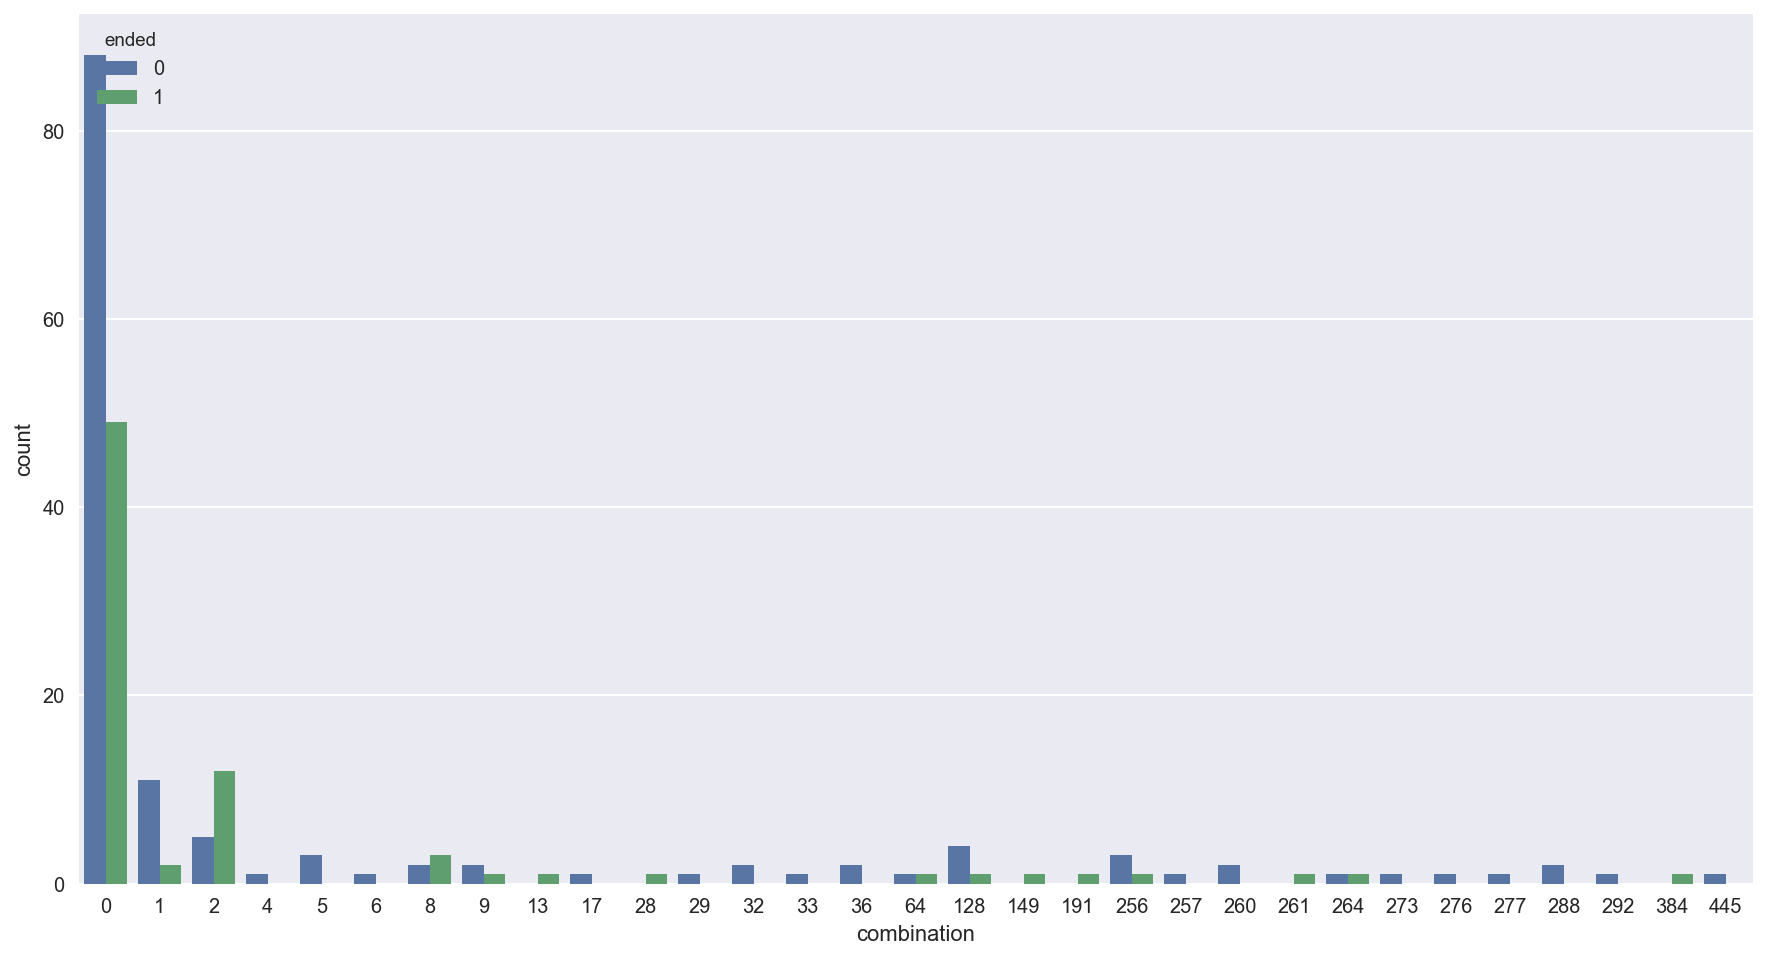

In [285]:
pa_incompatibility_ter['UN'] = pa["UN"]
pa_incompatibility_ter['ended'] = pa['ended']
plt.figure(figsize=(15,8))
sns.countplot(x='combination', data=pa_incompatibility_ter, hue='ended')
#plt.yscale('log')

There is no significant difference between UN agreements and the rest to display it. However we can see with this plot that when agreements have territorial provisions, it generally concerns the demarcation of a border or the government granting the disputed region to the other warring party.

In [ ]:
lst = [list(i) for i in itertools.product([0, 1], repeat=7)]
print(lst[12])

## Justice variables analysis
Run whatcombi box with n = 4

In [287]:
pa_justice = pa.iloc[:, 37:41]
# study ended results in fct of all combinations of the binary features
pa_justice.head()

,Amn,pris,Recon,Return
0,0,0,0,0
1,0,1,0,1
2,0,1,0,0
3,1,0,0,1
4,0,1,1,0


In [288]:
# run only once
pa_justice['combination'] = pa_justice.apply(whatcombi, axis=1)

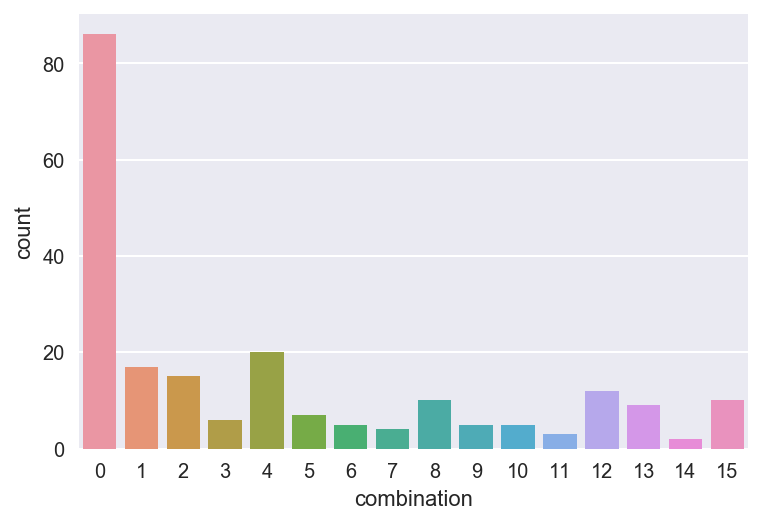

In [289]:
sns.countplot(x='combination', data=pa_justice)

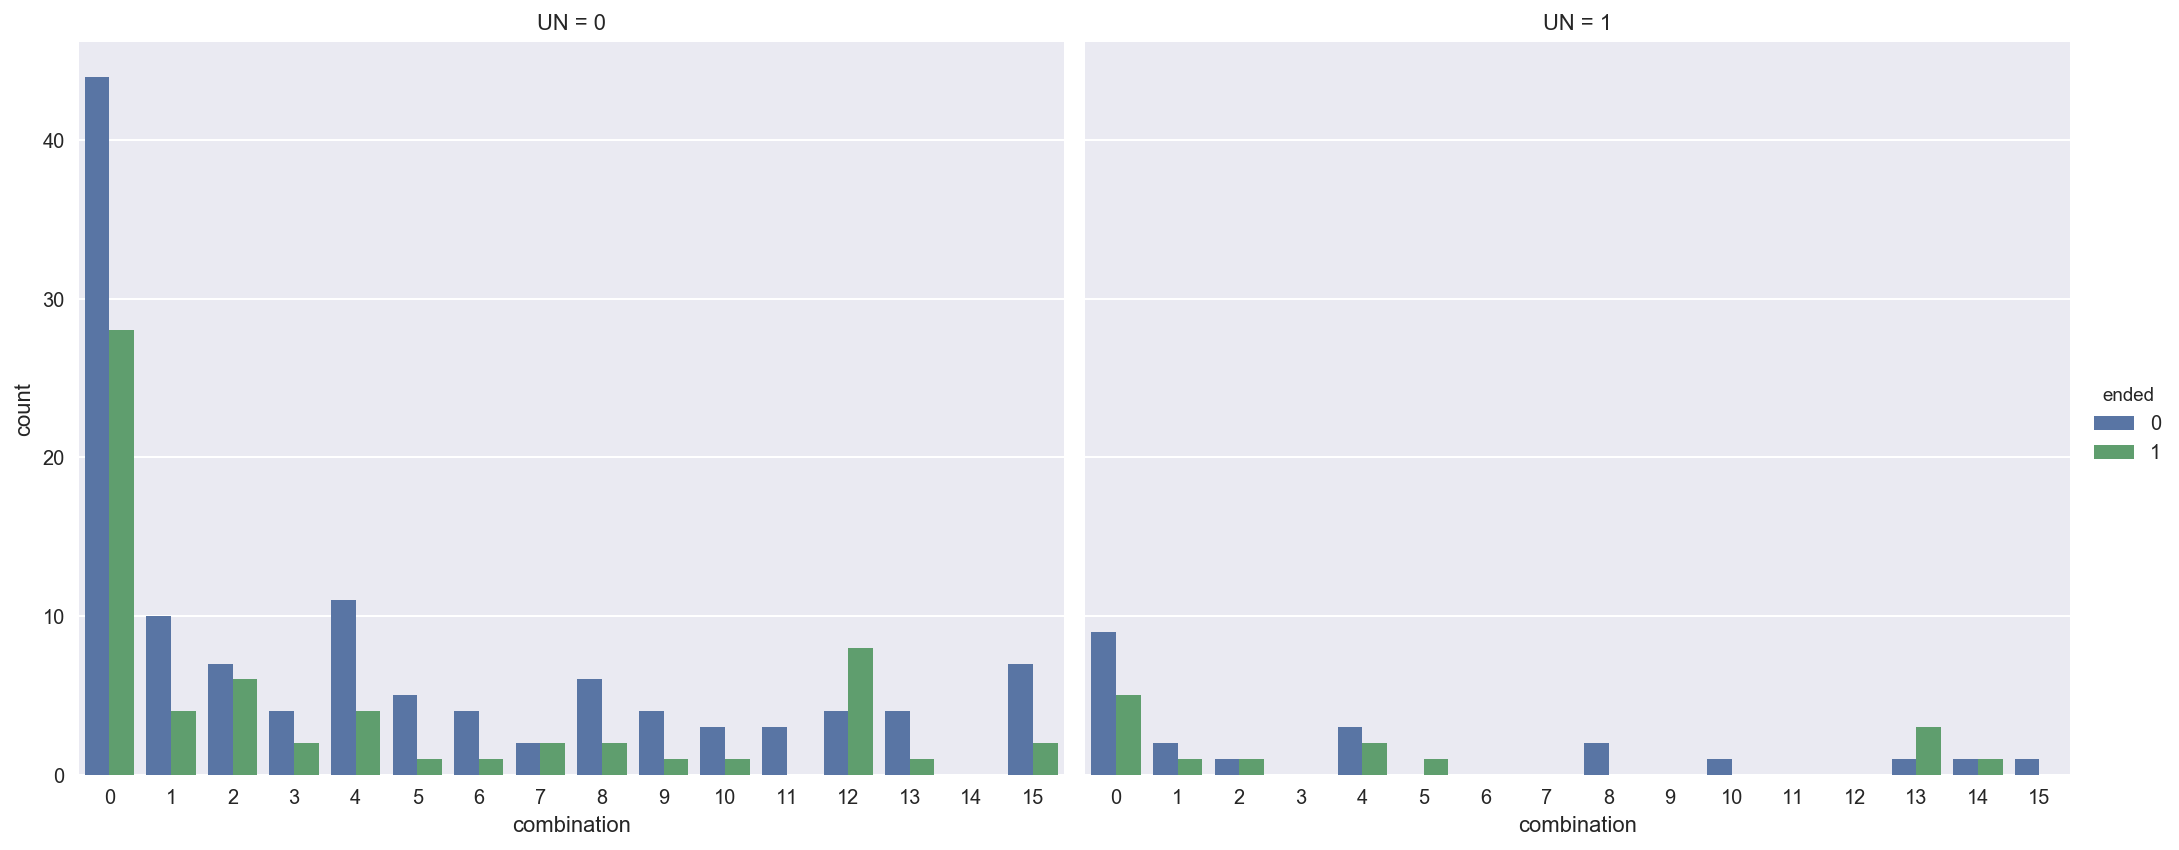

In [290]:
pa_justice['UN'] = pa["UN"]
pa_justice['ended'] = pa['ended']
sns.factorplot(x='combination', data=pa_justice, hue='ended', col='UN', kind='count', size=6, aspect = 1.2)

- The most recurring combination is the one where no justice issues is treated in the agreement.
- The second most recurring is the one where the agreement provided a release of prisoners

It seems like UN agreements uses a smaller amount of combinations than other agreements, particularly, the combination 13 corresponding to an amnesty, a release of prisoners and the return of refugees. Again this interpretation has to be understood with modesty as we lack data to be more consistent. A less naïve analysis will be made later to solve this issue.

The *Justice_prov* feature is set to one if any of the justice provisions was applied in the agreement. This variable could be of good use to reduce the number of features and keep an insight of the rather or not 'Justice' issues treated in the agreement.

## Implementation variables analysis

In [291]:
pa_implementation = pa.iloc[:, 42:46]
# study ended results in fct of all combinations of the binary features
pa_implementation.head()

,Reaffirm,Outlin,PKO,Co_impl
0,0,1,0,0
1,0,0,0,0
2,0,1,0,1
3,0,1,1,0
4,0,0,0,1


In [292]:
# run only once
pa_implementation['combination'] = pa_implementation.apply(whatcombi, axis=1)

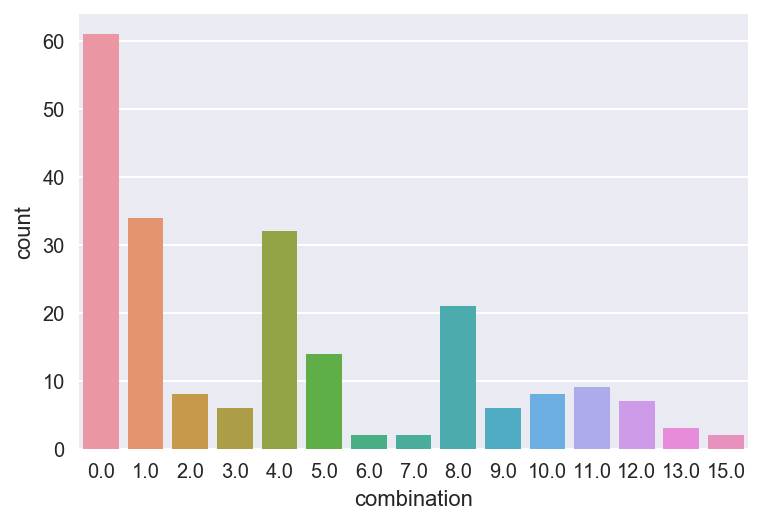

In [293]:
sns.countplot(x='combination', data=pa_implementation)

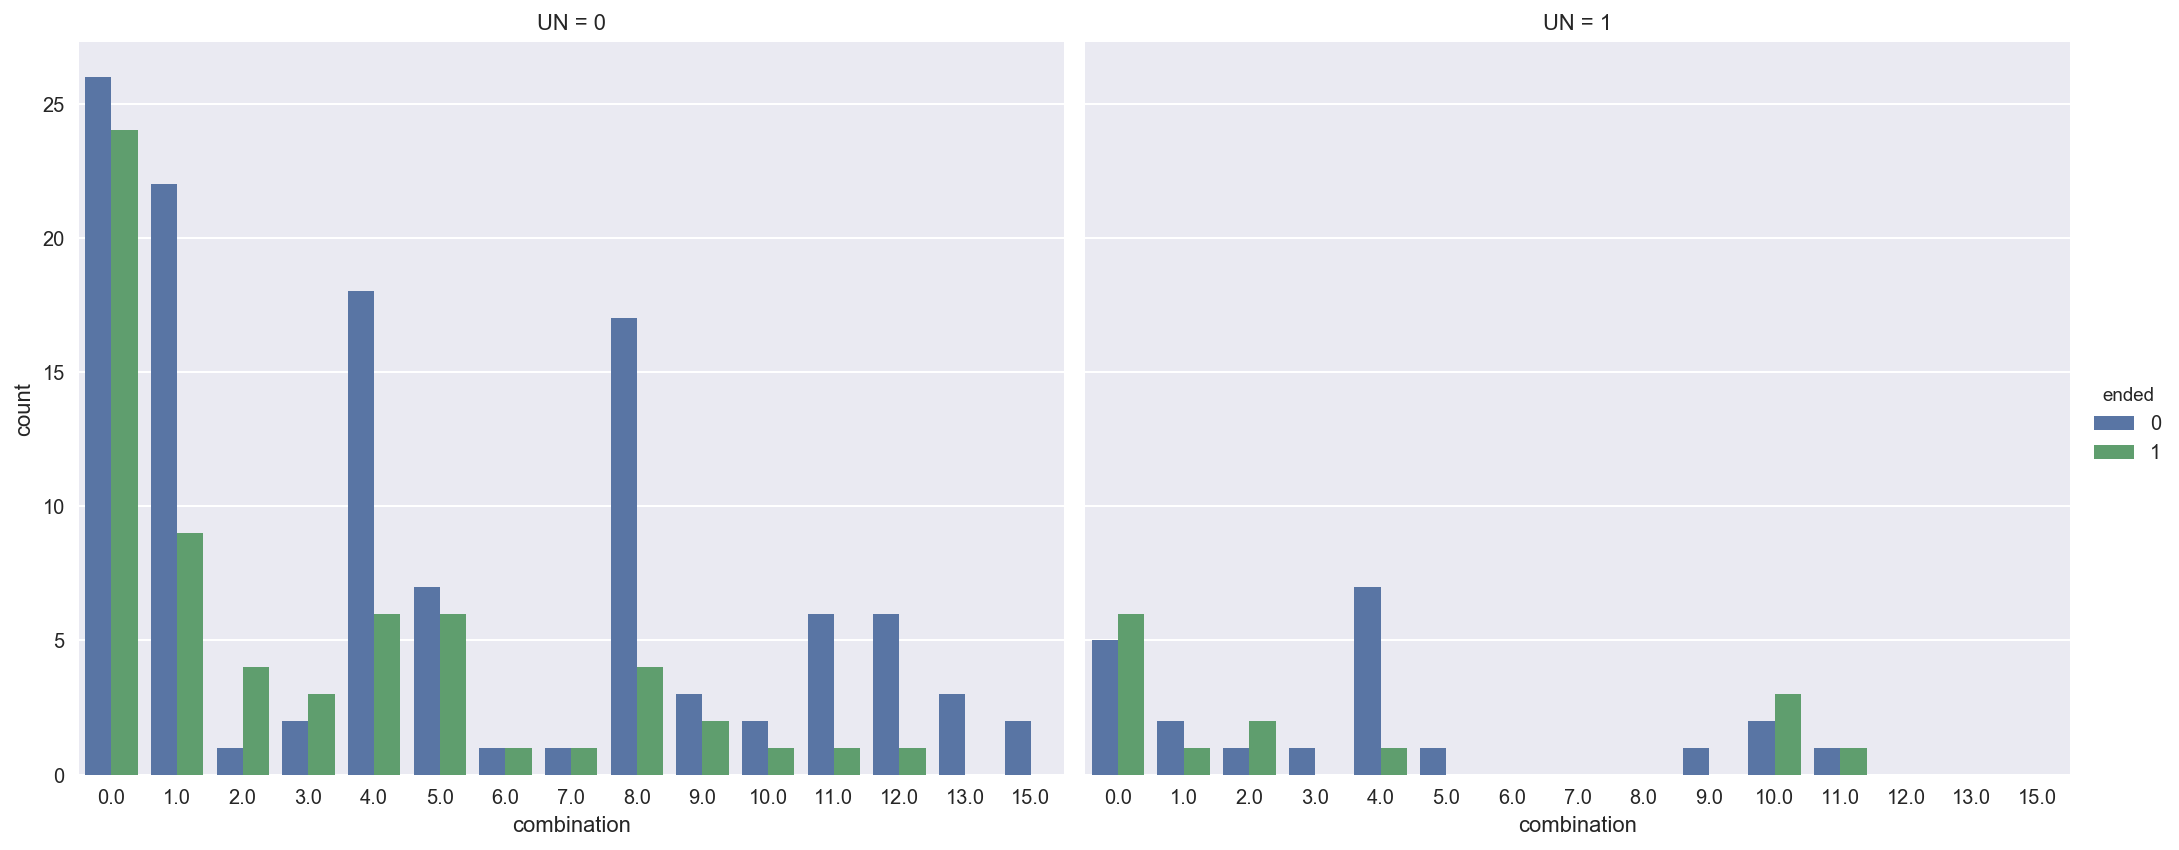

In [294]:
pa_implementation['UN'] = pa["UN"]
pa_implementation['ended'] = pa['ended']
sns.factorplot(x='combination', data=pa_implementation, hue='ended', col='UN', kind='count', size=6, aspect = 1.2)

- The most recurring implementation is the one where the agreement did not reaffirm earlier agreements, did not outline a negotiating agenda including negotiations on the incompatibility, did not provide for the deployment of a peace-keeping operation and did not provide for the establishment of a commission or committee to oversee implementation of the agreement.

- The second most combination recurring only provided for the establishment of a commission or committee to oversee implementation of the agreement.

- The third most recurring combination outline a negotiating agenda including negotiations on the incompatibility

- Fourth : reaffirm earlier agreements and provided the establishment of a commission or committee to oversee implementation of the agreement.

A small diference between the agreements where the UN was involved and those where it wasn't are the ones where a provision for peace keeping operations is made. This is of course logical because the UN is the entity that generally decides for such missions.

In [ ]:
lst = [list(i) for i in itertools.product([0, 1], repeat=4)]
print(lst[10])

## Temination variables
- **DyVi05** - Violence with the same parties restarted within 5 years

    - 1) Yes, the dyad violence restarted or continued
    - 0) No, the violence ended in this dyad
    - -99) Not applicable, agreement signed previous year


- **CoVi01** - Terminated the whole conflict the following year, signed an active year
    - 2) Part of a peace process which ended the violence.
    - 1) Yes, the conflict was terminated
    - 0) No, the conflict continued
    - -99) Not applicable, for example, the peace agreement was not signed in a conflict active year.


- **noconf** - Signed in a conflict inactive year.

The peace agreement was signed in an inactive conflict year i.e. in a year with less than 25 battle- related deaths recorded by the UCDP.
    - 1) Yes 
    - 0) No

- **termdur** - Number of years since last activity.

The number of inactive years between end of conflict and signature of the peace agreement.


- **Noconf11** - Still terminated as of 2011
    No active conflict years recorded from agreement until 2011 1) Yes, no active conflict years from agreement til 2011, 
    - 0) No, conflict restarted before 2011
    - -99) Not applicable, signed in 2011
    
The *termdur* will be used to relate agreement signed on active years to ones signed on inactive year. This should allow us to give more strentgh to an agreement that was signed fewer years after the end of the conflict than one signed a long time after. 

The *DyVi05* feature will be used as the second success evaluation variable. The *CoVi01* feature will be used to evaluate the time efficiency of the agreement.

# Check propensity scores

In [3]:
#let's reimport the data as we used it a lot in the previous analysis, we want it to be clean
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
cols = ['bwdID', 'pa_comment', 'c_sign', 'c_3rd', 'c_duration', 'Reaffirm ID', 'Comment', 'txt', 
        'Link to fulltext agreement', 'ProcID', 'Frame', 'All', 'Counter' , 'Duration']
pa.drop(columns=cols, inplace=True)

In [5]:
#some further cleaning
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('UN')]
pa["UN"] = [1 if ele in pa_UN.CID else 0 for ele in pa.CID]

to_be_categorical = ['termdur' , 'noconf11' , 'CoVi01' ,'DyVi05' ]
for categ in to_be_categorical:
    pa[categ] = pd.Categorical(pa[categ] , pa[categ].unique())
pa.groupby('UN').count()

,PAID,Region,GWNO,CID,Name,DyadName,actorId,Inc,pa_name,Year,...,Co_impl,DyVi05,CoVi01,noconf,termdur,noconf11,inclusive,no_dyad,pa_type,Out_iss
UN,,,,,,,,,,,,,,,,,,,,,
0,181,181,181,181,181,181,181,181,181,181,...,181,181,181,181,181,181,181,181,181,181
1,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35


In [6]:
import sklearn.linear_model
import sklearn.preprocessing
#removing the useless features
pa_reg = pa.iloc[:, 13:-1]
#prepocess by standardizing the dataset
pa_reg = preprocessing.scale(pa_reg)
#Perform a logistic regression in order to get the propensity score for each individuals
model = sklearn.linear_model.LogisticRegression()
model.fit(pa_reg, pa.UN)
pred = model.predict_proba(pa_reg)

Here we check the performance of our model, we have an accuracy of 89% which is quite good for a very simple logistic regression.

In [7]:
#Check the performance of the model
sum(model.predict(pa_reg) == pa.UN)/len(pa_reg)

0.8981481481481481

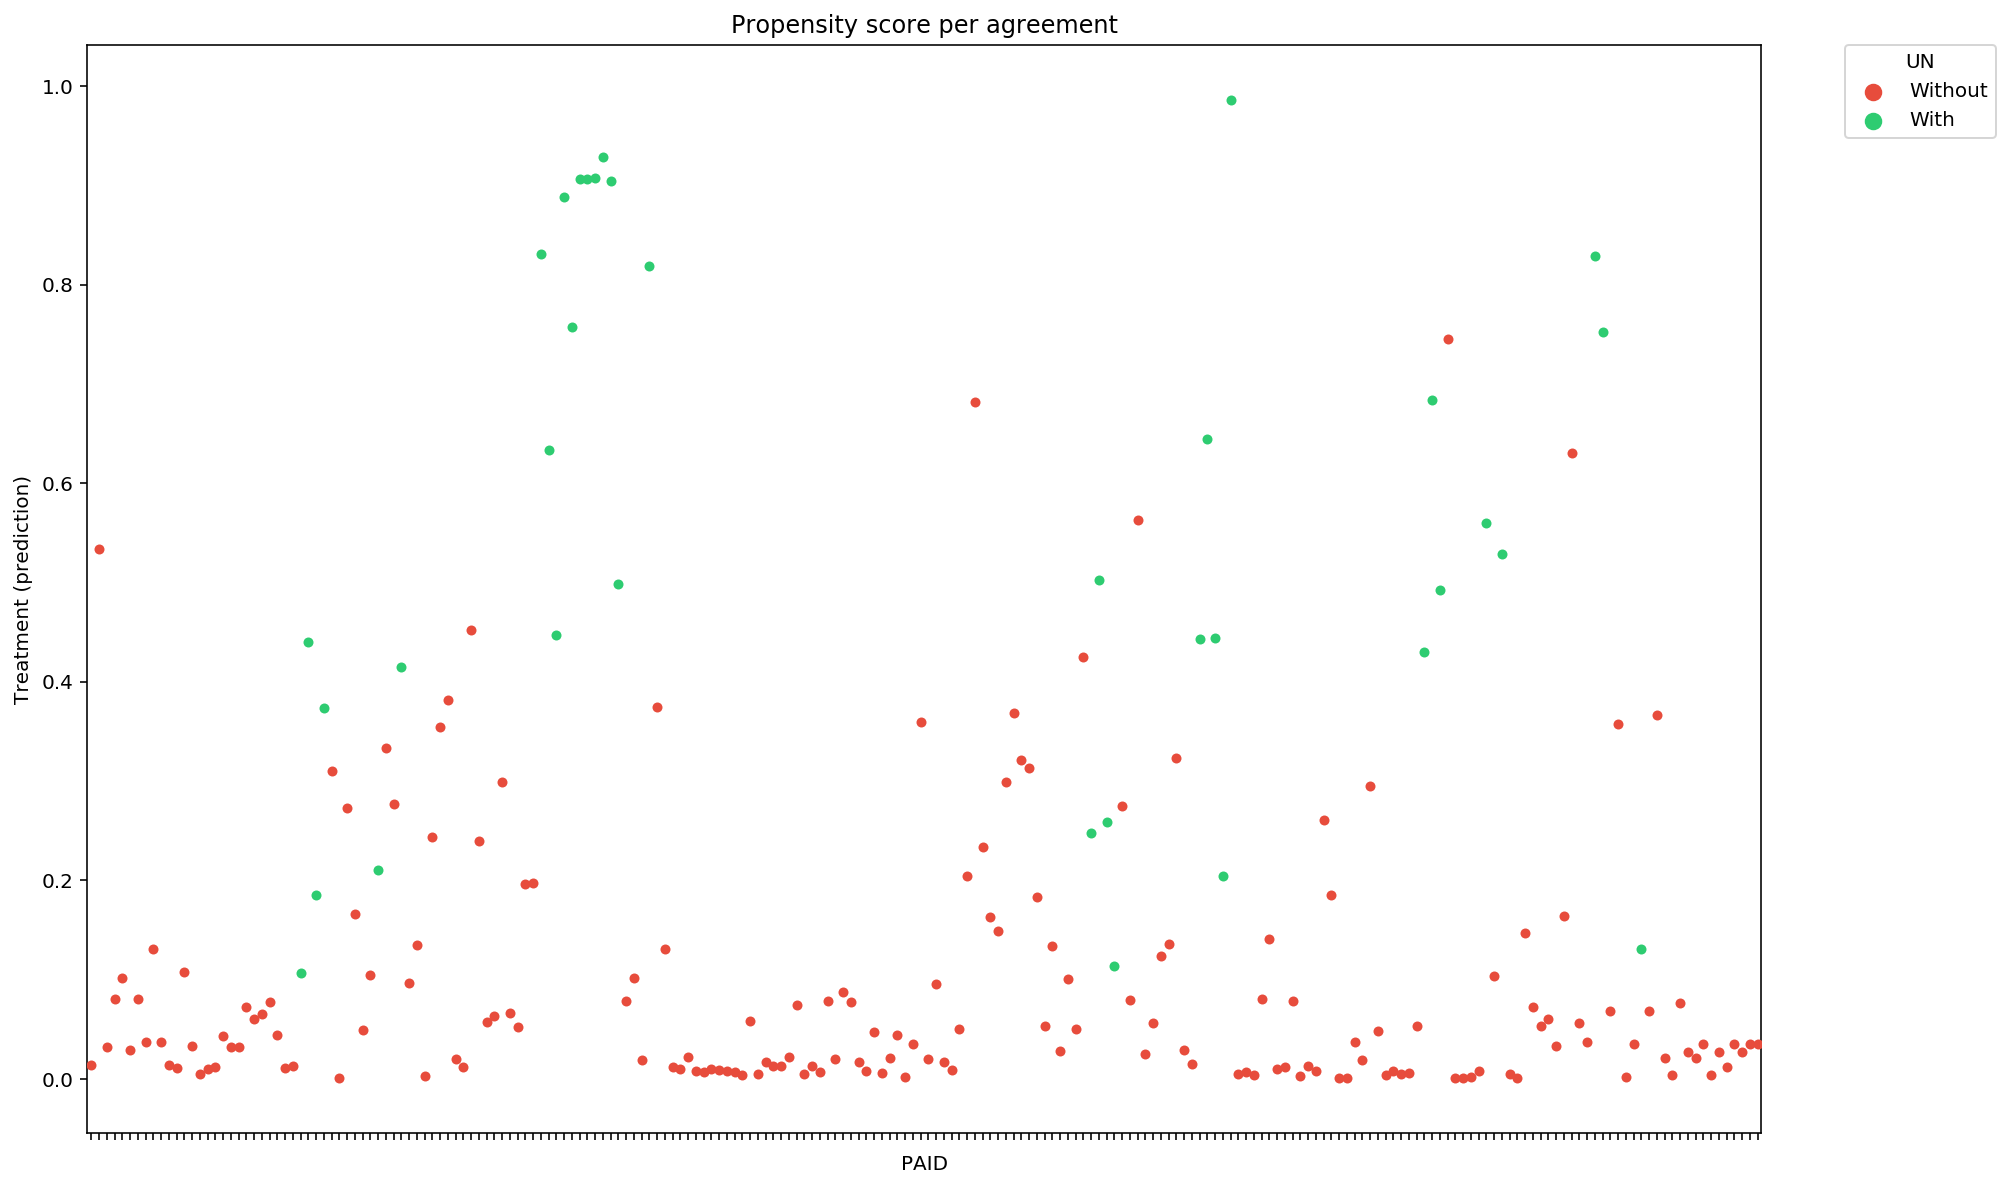

In [9]:
#Scatter plot of the propensity score
plt.figure(figsize=(15, 10))
pa['pred'] = pred[:,1]
ax = sns.stripplot(x='PAID', y='pred', hue='UN', data=pa, palette={0:"#e74c3c", 1: "#2ecc71"})
ax.set(xticklabels=[], ylabel='Treatment (prediction)')
plt.title('Propensity score per agreement')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=ax.get_legend_handles_labels()[0], labels=['Without', 'With'], title='UN')

This plot shows us what the propensity score for each PAID is. The UN PAID are in green and should have a score around 1 whereas the PAID without the UN are in red and should have a score around 0. Even if we have some outliers, this is what we observe on the plot.

In [10]:
#Check that every PAID has a pred value
pa.pred.isnull().values.any()

False

Here we do the matching.

We saw in class that matching among the propensity score is almost the same as matching among the features.

In order to do this matching, we will procede in the following way:


- First, we will create a complete bipartite graph. It means that the vertices are partitioned into two subsets V1 (the people who received the training) and V2 (the people who did not receive the traing) such that no edge has both endpoints in the same subset, and every possible edge that could connect vertices in different subsets is part of the graph. This way will will be sure to match UN PAID people with PAID without the UN

- We will give a weight to these edges: Let's take two PAID,we denote by $w_1$ the propensity score of the UN PAID and $w_2$ the propensity score of the other PAID (no UN). The weight of the edge between them will be:
$$W = - |w_{1} - w_{2}| $$

- Finally we will use a maximum weight matching with max cardinality algorithm. Note that we have a minus sign in our weights because we want to minimize the weights even though we are using a maximum weight matching algorithm. We are using the method implemented in the NetworkX package. This method is based on the “blossom” method for finding augmenting paths and the “primal-dual” method for finding a matching of maximum weight, you can read more about it there : https://dl.acm.org/citation.cfm?id=6502 .

In [11]:
import networkx as nx
from networkx.algorithms import bipartite

#create the nodes
G=nx.Graph()
G.add_nodes_from(pa['PAID'][pa.UN == 0])
G.add_nodes_from(pa['PAID'][pa.UN == 1])

In [12]:
#Bipartite complete graph
for ID_u, score_u in zip(pa.PAID[pa.UN == 0], pa.pred[pa.UN == 0]):
    for ID_v, score_v in zip(pa.PAID[pa.UN == 1], pa.pred[pa.UN == 1]):
        G.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))

In [13]:
#Let's check if the number of nodes and edges is right
#Number of nodes should be 185+429 = 614 (the graph is bipartite) and number of edges should be 185*429 = 79365
#because it is complete bipartite
print(G.number_of_nodes())
print(G.number_of_edges())

216
6335


In [14]:
#perform the matching
from networkx.algorithms import max_weight_matching
matching = max_weight_matching(G, maxcardinality=True)

In [15]:
#We have 35 PAIDs that need to be matched, here we notive the dictionnary goes in both ways
len(list(matching.items()))

70

In [16]:
pa_UN = pa[pa['UN'] == 1]
pa_UN['temp'] = 1
pa_UN = pa_UN[['PAID' , 'pred' , 'temp']]
pa_nUN = pa[pa['UN'] == 0]
pa_nUN['temp'] = 1
pa_nUN = pa_nUN[['PAID' , 'pred' , 'temp']]


#We merge the two datasets thanks to the temp column, this new merged dataset mimics the complete bipartite graph:
result = pd.merge(pa_nUN ,pa_UN , on='temp', how='left')
result = result[['PAID_x' , 'PAID_y' , 'pred_x' , 'pred_y']]
result['diff'] = abs(result['pred_x'] - result['pred_y'])
result = result.set_index(['PAID_x', 'PAID_y'])
result['diff'].isnull().values.any()
#result
print(result.loc[list(matching.items())].dropna().shape)
result.loc[list(matching.items())].dropna().head()

(35, 3)


,,pred_x,pred_y,diff
PAID_x,PAID_y,,,
5162008120401,3461994030101,0.204083,0.210589,0.006506
901994061701,47548319830711,0.131033,0.131480,0.000447
6252005061801,1002001020901,0.185827,0.185024,0.000803
4822007041301,3721994040401,0.374566,0.414823,0.040258
901996091901,5402002040401,0.107668,0.113870,0.006202


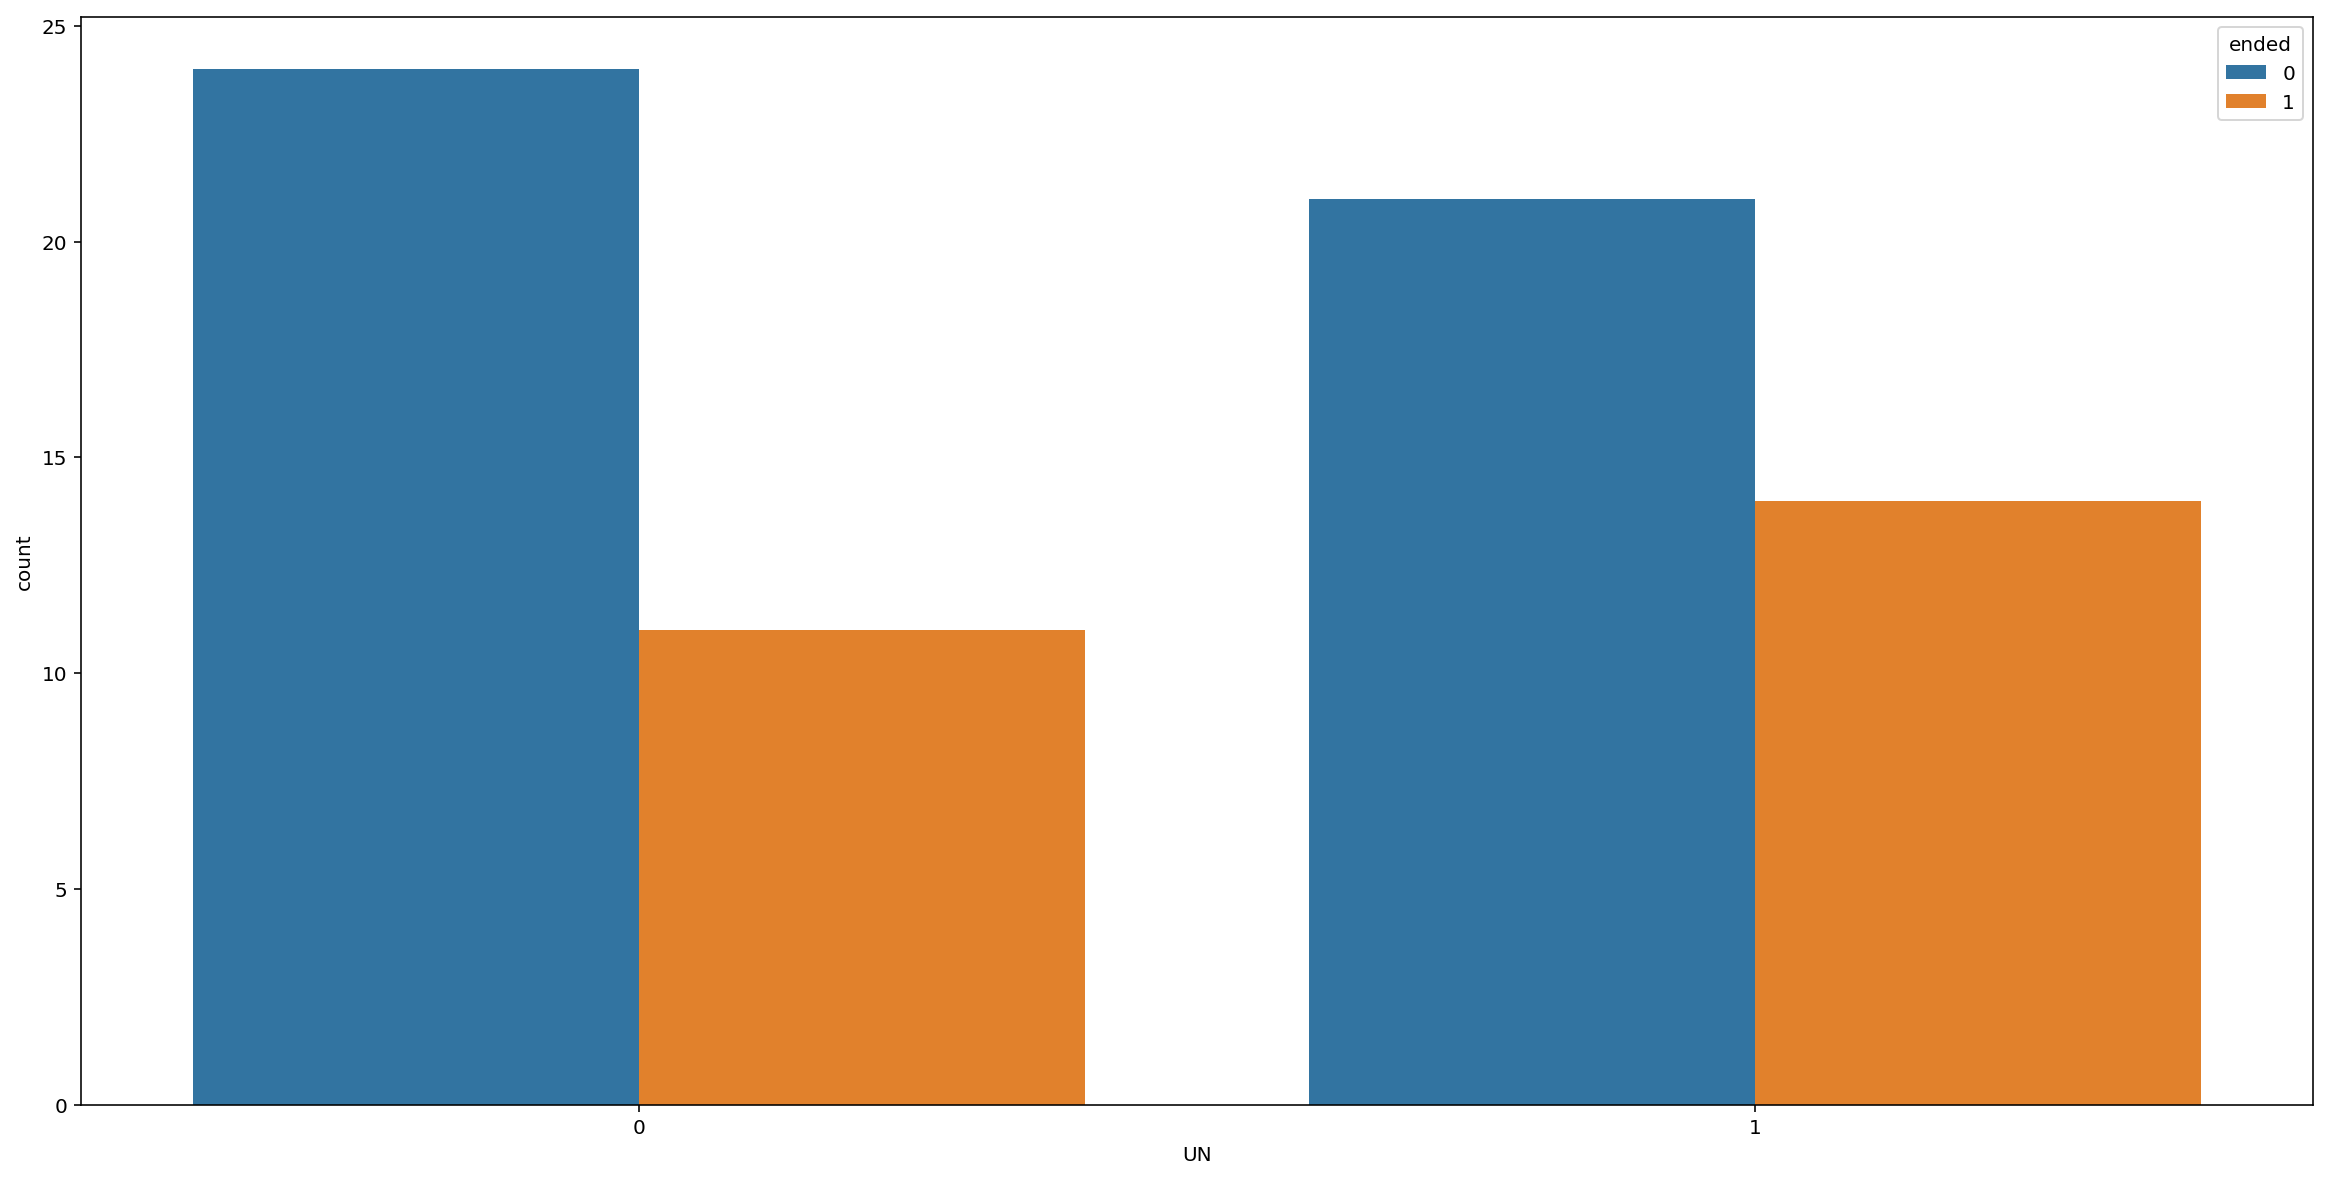

In [17]:
paID = pa.set_index('PAID')
matched = paID.loc[list(matching.keys())]
plt.figure(figsize=(20,10))
sns.countplot(x='UN', data= matched, hue='ended')

The UN agreements are more 'ended' (so the conflicts start again) than the one without the UN interention.
But note that this analysis is still biased! 
Indeed, we only looked at the peace agreements here, we also need to look at the conflicts from these peace agreements. Maybe the UN only solved very difficult conflicts.
In a second part we will look at the conflict that were solved and do another matching among them so we can redo this analysis with a filter on the conflict (will be done for markdown 3)

# Conflicts

## Cleaning the data

As we studied in the previous part, we will need to balance our study over the conflict that has be solved by the UN vs the others.

Indeed, the previous dataset only gave us informations about the peace agreement per se, we did not have any information about the conflict itself.

UCDP has another data set that describes the conflicts. It is named *ucdp-prio-acd*.

It is a conflict-year dataset with information on armed conflict where at least one party is the government of a state in the time period 1946-2016.

The Conflict IDs are not the same between *ucdp-peace-agreements* and *ucdp-prio-acd* because UCDP changed the way the give IDs. The dataset *ucdp-peace-agreements* uses the old ID notation while *ucdp-prio-acd* uses the new one . Therefore, we need the translation give bt UCDP, *translate_conf*, to link them.

In [15]:
#Import the Peace Agreement dataset and the translation table to get the new IDs
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
reader = csv.reader(open('data/translate_conf.csv', 'r'))

#Create a dictionnary that will have {New ID : Old ID} so we can make the link
d = {}
for row in reader:
    k, v = row
    d[v] = k
    
pa.CID = pa.CID.astype(dtype=str).replace(to_replace=d )
pa.CID = pa.CID.astype(dtype = int)

In [16]:
#Import the conflict dataset
df = pd.read_csv('data/ucdp-prio-acd-171.csv')

In [17]:
#Let's observe the data
df.iloc[:10, :11]

,conflictid,location,sidea,sidea2nd,side b,sidebid,sideb2nd,incomp,terr,year,intensity
0,200,Bolivia,Government of Bolivia,NaN,Popular Revolutionary Movement,719,NaN,2,NaN,1946,2
1,200,Bolivia,Government of Bolivia,NaN,MNR,720,NaN,2,NaN,1952,1
2,200,Bolivia,Government of Bolivia,NaN,ELN,721,NaN,2,NaN,1967,1
3,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1946,1
4,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1947,1
5,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1948,1
6,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1949,1
7,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1950,1
8,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1951,1
9,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1952,1


In [18]:
#Lot's of features so we do that in two times
df.iloc[:10, 11:27]

,cumint,type,startdate,startprec,startdate2,startprec2,epend,ependdate,ependprec,gwnoa,gwnoa2nd,gwnob,gwnob2nd,gwnoloc,region,version
0,1,3,1946-07-18,1,1946-07-21,2,1,1946-07-21,1.0,145,NaN,NaN,NaN,145,5,17.1
1,1,3,1946-07-18,1,1952-04-09,1,1,1952-04-12,1.0,145,NaN,NaN,NaN,145,5,17.1
2,1,3,1946-07-18,1,1967-03-31,3,1,1967-10-16,1.0,145,NaN,NaN,NaN,145,5,17.1
3,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
4,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
5,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
6,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
7,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
8,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
9,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1


As we notice, there is several rows for the same conflict ID. Indeed, Each conflict is listed in the database and given a unique ID code. The temporal aspect of a conflict is not addressed by this definition; hence, two conflict episodes over the same incompatibility will be assigned the same ID regardless of the time separating them.

This is how UCDP records the data, as explained on their website:

- The observation (or unit) in the table is the conflict-year. Each conflict is listed in all years where fighting in one or more dyad(s) caused at least 25 battle-related deaths. The calendar year is the basic unit of every observation. Thus, if a conflict during the period June–September results in 30 casualties, that year will be recorded as a year of conflict. However, if the same number of casualties occurred in the period November–February and the conflict failed to reach the threshold of 25 battle-related deaths in either calendar year, neither year will be coded as in conflict. Start dates frequently refer to years prior to the first calendar year of a conflict, as the start of a conflict might be in a year with less than 25 fatalities. Small conflicts might not be included.

Taking this into account, we decide to refine this dataset in order to have a single conflict ID per row. In order to do that we will aggregate the dataset at the CID (Conflict ID) level. To do so we will drop some variables that only concern the years of observation and not the conflict in its totality. This variables are :

- `year` : The year of observation, which is not needed anymore as we will observe the conflict in its totality

- `intensity` : The intensity of the conflict in a given year.

- `startdate2` : The starting date of the observation (for a given year then, not the conflict itself).

- `startprec2` : The precision of the `startdate2` variable.

- `epend` : The ending date of the observation (same as above).

- `ependprec` : The precision of the `epend` variable.

These are the variables we droppend because we aggregate the dataset. We will drop some other variables because they are not needed in our analysis :

- `sidea2nd` : If there is a secondary actor in the conflict on side A, we don't think we need that much precision.

- `sideb2nd` : If there is a secondary actor in the conflict on side B, we don't think we need that much precision.

- `terr` : The disputed territory if there is any. We don't need that much precision for a propensity score.

- `startprec` : The precision of the starting date for the conflict. This is useless for our propensity score.

- `gwnoa`, `gwnoa2nd`, `gwnob`, `gwnob2nd`, `gwnoloc` : This is only country codes etc, we don't need that for a propensity score.

- `version` : The version of the dataset.

We will describe the variables we keep in the next markdown, after we show the clean data set.

In [19]:
#Let's remove the features we don't need for our analysis
df.drop(['sidea2nd', 'sideb2nd' , 'terr' , 'year' , 'intensity' , 'startprec' , 'startdate2' , 'epend' , 'ependprec', 'gwnoa', 'gwnoa2nd', 'gwnob', 'gwnob2nd', 'gwnoloc', 'startprec2', 'version', 'sidebid'], axis=1, inplace = True)

In [20]:
#Check how many conflicts we have
print('Number of unique conflicts in this dataset : %s' %(len(df.conflictid.unique())))

Number of unique conflicts in this dataset : 280


In [21]:
print("Number of non-unique locations for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['location'].unique().apply(len) > 1)]))
print("Number of non-unique 'side a' for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['sidea'].unique().apply(len) > 1)]))
print("Number of non-unique 'side b' for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['side b'].unique().apply(len) > 1)]))
print("Number of non-unique incomp for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['incomp'].unique().apply(len) > 1)]))
print("Number of non-unique cumint for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['cumint'].unique().apply(len) > 1)]))
print("Number of non-unique types for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['type'].unique().apply(len) > 1)]))
print("Number of non-unique startdates for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['startdate'].unique().apply(len) > 1)]))
print("Number of non-unique regions for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['region'].unique().apply(len) > 1)]))

Number of non-unique locations for a single conflict: 0
Number of non-unique 'side a' for a single conflict: 0
Number of non-unique 'side b' for a single conflict: 84
Number of non-unique incomp for a single conflict: 0
Number of non-unique cumint for a single conflict: 76
Number of non-unique types for a single conflict: 49
Number of non-unique startdates for a single conflict: 0
Number of non-unique regions for a single conflict: 0


In [22]:
#Let's aggregate the data to single CIDs (explanations in the markdown below)
clean_df = df.groupby('conflictid').last()
clean_df.head()

,location,sidea,side b,incomp,cumint,type,startdate,ependdate,region
conflictid,,,,,,,,,
200,Bolivia,Government of Bolivia,ELN,2,1,3,1946-07-18,1967-10-16,5
201,Cambodia (Kampuchea),Government of France,Khmer Issarak,1,0,1,1946-08-31,1953-11-09,3
202,China,Government of China,PLA,2,1,3,1946-12-31,1949-12-08,3
203,Greece,Government of Greece,DSE,2,1,3,1946-03-31,1949-10-16,1
204,Indonesia,Government of Netherlands,Indonesian People's Army,1,0,1,1945-10-13,1949-08-15,3


Here we will explain the variables we retained and how we aggregated them:

- `location` : The location of the conflict, this is always the same for each conflict ID, therefore we just take the value of the last observation for the aggregated dataset.

- `sidea` : The first agent in the conflict (it has to be a government), this is always the same for each conflict ID, therefore we just take the value of the last observation for the aggregated dataset.

- `side b` : The seconf agent in the conflict (it can be a government or an organisation), this is not always the same but after organisation we noticed that it was due to the organisation often changing name. Therefore we use the name of the organisation in the last observation for the aggregated dataset.

- `incomp` : The incompatibility that led to the conflict. this is always the same for each CID, therefore we simply take the value of the last observation. Here are the three possible values :
    - 1 : Territory
    - 2 : Government
    - 3 : Both
    
- `cumint` : It is a variable that says if the conflict did more than 1000 battle related deaths since its begining. Of course it is not the same accross the same CID because it is a cumulative variable, therefore we take the value for the last observation.

- `Type` : The type of conflict. The type can change for the same CID. Though, we think that the most important is what the conflict was at its end (we have the `incomp` variable to tell us how the conflict began). Therefore, we take the last value for the aggregated dataset. There are four types of conflicts :
    - 1 : Extrasystemic armed conflict occurs between a state and a non-state group outside its own territory.
    - 2 : Interstate armed conflict occurs between two or more states. 
    - 3 : Internal armed conflict occurs between the government of a state and one or more internal opposition group(s) without intervention from other states.
    - 4 : Internationalized internal armed conflict occurs between the government of a state and one or more internal opposition group(s) with intervention from other states (secondary parties) on one or both sides.
    
- `startdate` : The date of the start of the conflict, it is the same across all raws for the same CID so we can take whatever line when we aggregate.

- `ependdate` : The end date of the episode observed. If this is the last episode it is the date of the end of the conflict for the CID. We take the date of the last observation when we aggregate then.

- `region` : The region of the conflict, it is always the same across the same CID. Then we take the one for the last observation. The 5 regions are : 
    - 1 : Europe
    - 2 : Middle East
    - 3 : Asia
    - 4 : Africa
    - 5 : America
    
    
Now we will use the other dataset in order to know if there was a Peace Agreement for this conflict. We will add a 0/1 column to capture this information.

In [23]:
#Check the CIDs that were ended by a peace agreement
agreements = pa.groupby('CID').last()
print('Number of unique conflicts that had a peace agreement : %s' %(len(agreements.index)))
print(agreements.index)

Number of unique conflicts that had a peace agreement : 60
Int64Index([  233,   234,   300,   308,   309,   314,   315,   316,   318,
              320,   322,   324,   327,   332,   333,   335,   337,   341,
              345,   349,   361,   366,   369,   372,   373,   374,   375,
              379,   381,   382,   384,   387,   389,   390,   392,   394,
              395,   398,   400,   403,   404,   405,   407,   408,   409,
              410,   412,   416,   417,   419,   421,   428,   435, 11344,
            13247, 13306, 13611, 13637, 13638, 13694],
           dtype='int64', name='CID')


In [24]:
#We add a column so we know if the CID had a peace agreement (1) or not (0)
clean_df["agreement"] = [1 if ele in agreements.index else 0 for ele in clean_df.index]
clean_df.rename({'ependdate':'enddate'} , inplace = True, axis = 1)

In [28]:
#We now have a clean dataset
clean_df.head(10)

,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement
conflictid,,,,,,,,,,
200,Bolivia,Government of Bolivia,ELN,2,1,3,1946-07-18,1967-10-16,5,0
201,Cambodia (Kampuchea),Government of France,Khmer Issarak,1,0,1,1946-08-31,1953-11-09,3,0
202,China,Government of China,PLA,2,1,3,1946-12-31,1949-12-08,3,0
203,Greece,Government of Greece,DSE,2,1,3,1946-03-31,1949-10-16,1,0
204,Indonesia,Government of Netherlands,Indonesian People's Army,1,0,1,1945-10-13,1949-08-15,3,0
205,Iran,Government of Iran,KDPI,1,1,3,1946-05-31,1996-07-28,2,0
206,Iran,Government of Iran,Republic of Azerbaijan,1,0,4,1945-11-19,1946-12-16,2,0
207,Israel,Government of United Kingdom,IZL [Etzel],1,0,1,1939-03-31,1946-12-31,2,0
208,Laos,Government of France,Lao Issara,1,1,1,1946-03-31,1953-12-31,3,0


In [29]:
clean_df.tail(10)

,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement
conflictid,,,,,,,,,,
13648,Egypt,Government of Egypt,IS,1,1,3,2014-11-16,2016-12-06,2,0
13653,India,Government of India,UNLFW,1,0,3,2015-04-19,2016-12-31,3,0
13675,Lebanon,Government of Lebanon,IS,1,0,3,2014-06-25,2015-12-15,2,0
13692,"Afghanistan, United Kingdom, United States of ...",Government of Afghanistan,"Government of United Kingdom, Government of Un...",2,1,2,2001-10-07,2001-11-13,"1, 3, 5",0
13694,Libya,Government of Libya,IS,1,1,4,2015-03-14,2016-12-07,4,1
13721,Algeria,Government of Algeria,Jund al-Khilafah,1,0,3,2015-04-05,2015-05-20,4,0
13809,Syria,Government of Syria,SDF,3,0,3,2015-12-06,2016-11-28,2,0
13886,Jordan,Government of Jordan,IS,1,0,3,2016-03-02,2016-12-29,2,0
13902,Turkey,Government of Turkey,IS,1,1,3,2015-07-23,NaN,2,0


In [30]:
#Check that we have all the CIDs for peace agreement
clean_df[clean_df['agreement'] == 1].shape

(60, 10)

## Data exploration

In this section, we will observe the distributions for the conflict over the `agreement` variable as we will want to have a propensity score matching for the conflicts that did or did not receive a peace agreement. (And later for conflicts that did or did not receive a peace aggreement from the UN).

We don't have any problems of missing values in this dataset, the only that we encounterd are for `enddate` and it simply means that the conflict is ongoing.

The correlations we are interrested in are the ones of the different features with the `agreement` variable. These will be checked when we will plot the distributions.

In [31]:
#A function to have nice plots
def plot_distrib(s1, s2, title, xLabel, yLabel, ax=None):
    bins = np.histogram(s1)[1]
    sns.distplot(s1, kde=False, color=COLOR_NO_TREAT, norm_hist=True, ax=ax, bins=bins)
    sns.distplot(s2, kde=False, color=COLOR_TREAT, norm_hist=True, ax=ax, bins=bins)
    if ax is None:
        plt.title(title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.legend(['No agreement', 'Agreement'])

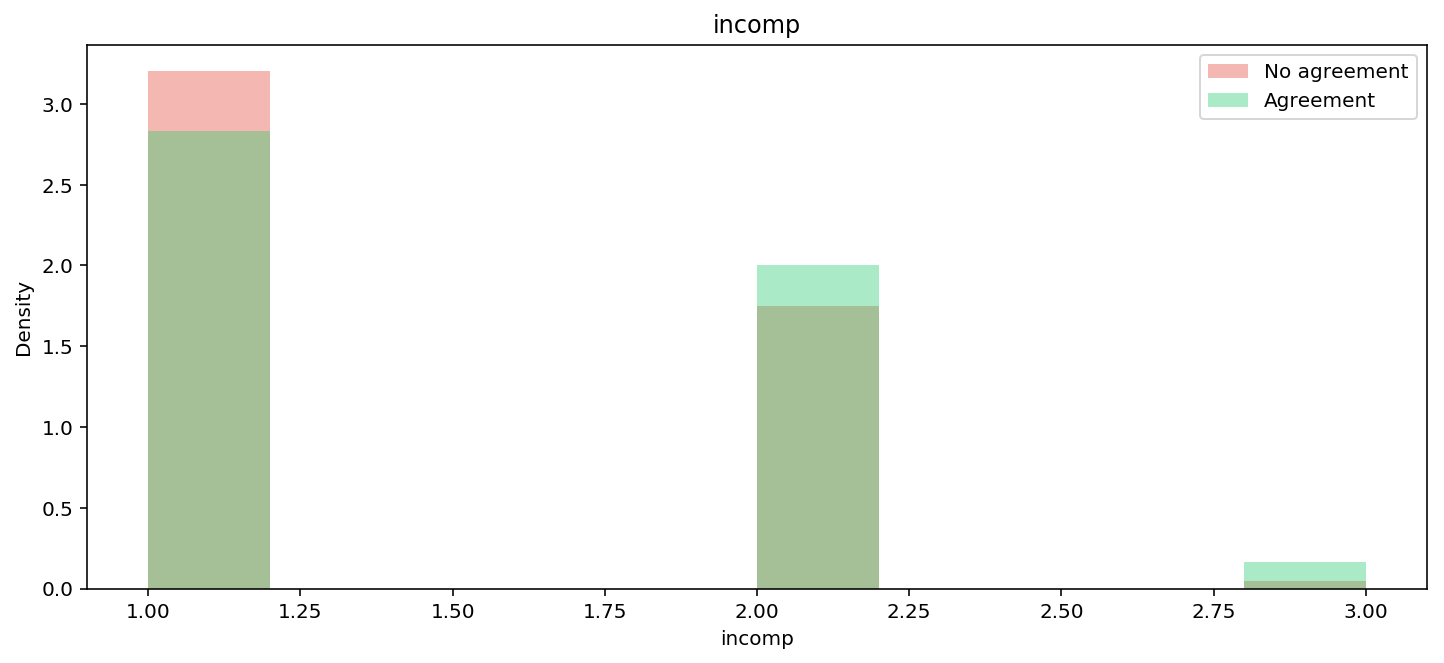

In [32]:
#Distrib for the incomp variable
plt.figure(figsize=(12,5))
plot_distrib(s1=clean_df['incomp'][clean_df['agreement'] == 0], s2=clean_df['incomp'][clean_df['agreement'] == 1], title='incomp', xLabel = 'incomp', yLabel='Density', ax=None)

In [33]:
#KS 2 sample test to check distrib
from scipy import stats 
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'incomp'
ks = stats.ks_2samp(clean_df['incomp'][clean_df['agreement'] == 0], clean_df['incomp'][clean_df['agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

incomp     0.074       0.950


#### `incomp` distribution

A Kolmogorov–Smirnov 2 sample test will help us be sure of our analysis.
The Kolmogorov–Smirnov 2 sample test tests whether 2 samples are drawn from the same distribution. If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

The `incomp` variable seems to be equally distributed across the `agreement` variable. Indeed, the plot and the Kolmogorov-Smirnov 2-sample tests both tell us that we can't reject the null hypothesis as the p-value is very high.

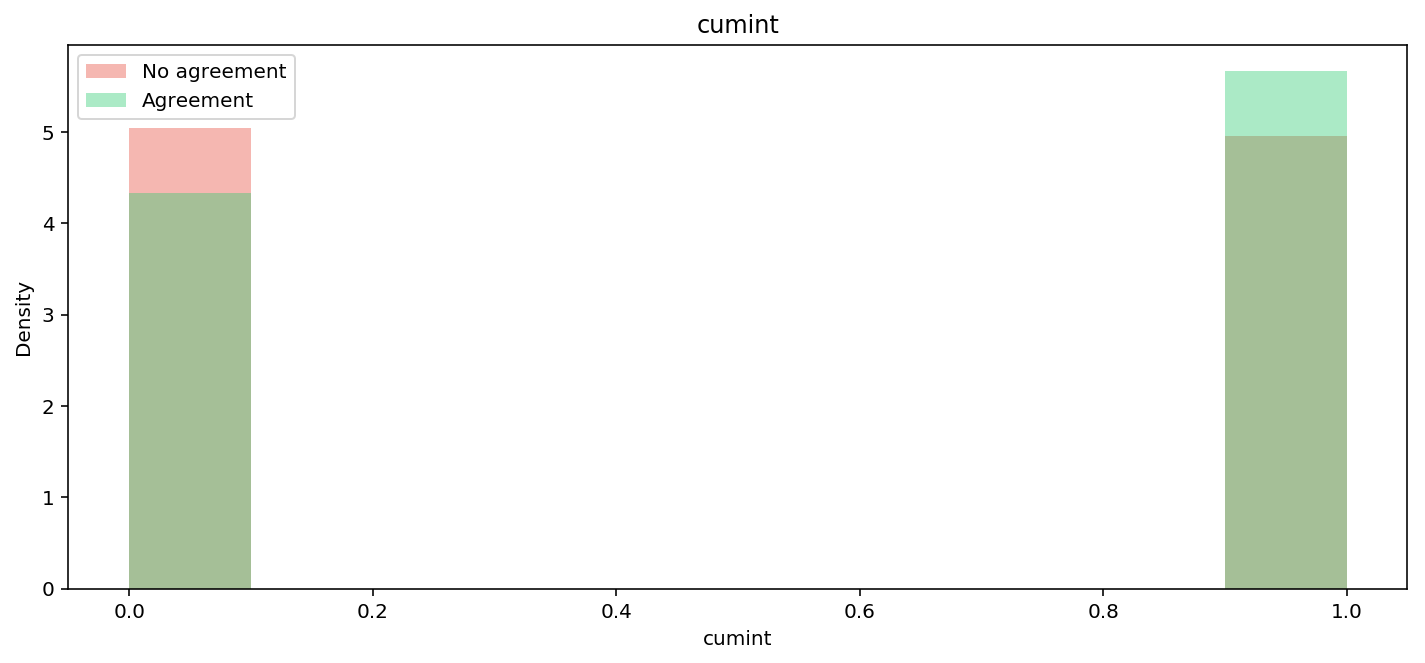

In [34]:
#plot the distrib
plt.figure(figsize=(12,5))
plot_distrib(s1=clean_df['cumint'][clean_df['agreement'] == 0], s2=clean_df['cumint'][clean_df['agreement'] == 1], title='cumint', xLabel = 'cumint', yLabel='Density', ax=None)

In [35]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'cumint'
ks = stats.ks_2samp(clean_df['cumint'][clean_df['agreement'] == 0], clean_df['cumint'][clean_df['agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

cumint     0.071       0.965


#### `cumint` distribution

Again the distributions are almost the same as seen on the plot. Furthermore, the p-value for the KS 2 sample test is very high (0.965) so we can't reject the null hypothesis.

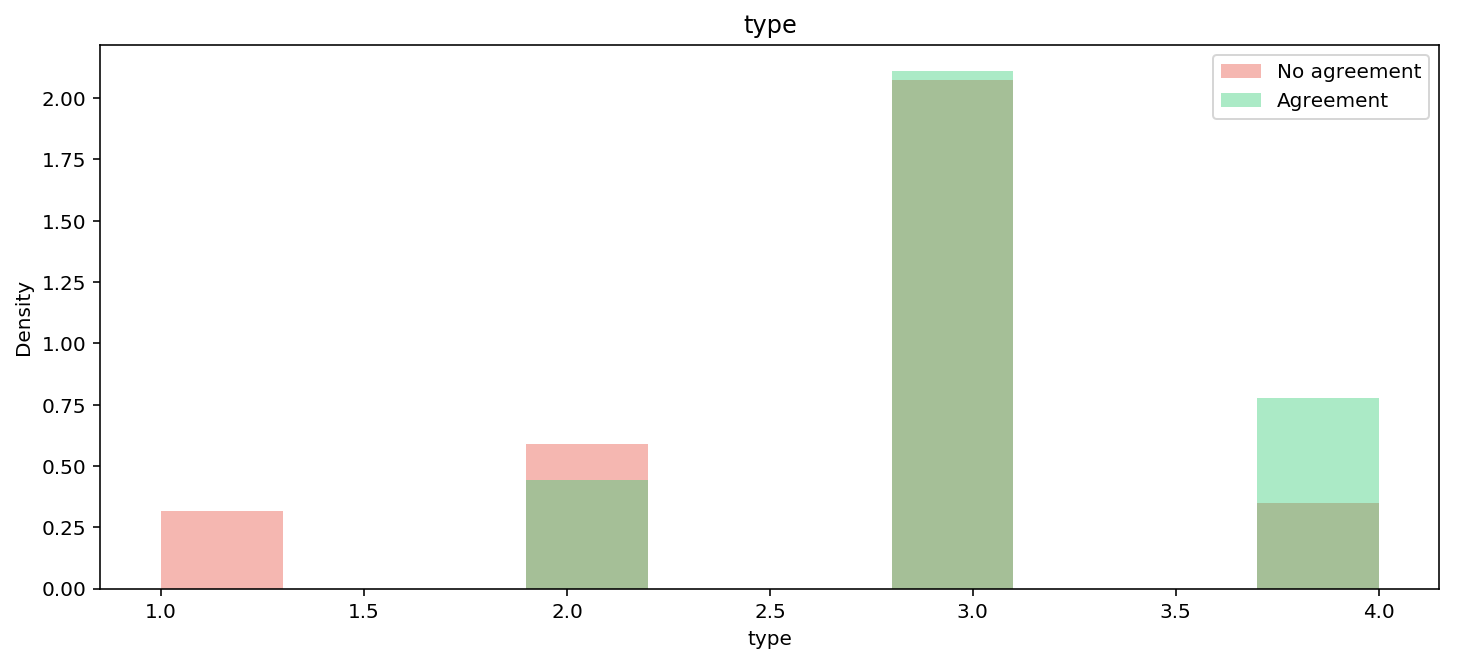

In [36]:
#plot the distrib
plt.figure(figsize=(12,5))
plot_distrib(s1=clean_df['type'][clean_df['agreement'] == 0], s2=clean_df['type'][clean_df['agreement'] == 1], title='type', xLabel = 'type', yLabel='Density', ax=None)

In [37]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'type'
ks = stats.ks_2samp(clean_df['type'][clean_df['agreement'] == 0], clean_df['type'][clean_df['agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

type       0.139       0.297


#### `type` distribution

Here the distrib look a bit different on the plot but the p-value for the KS 2 sample test tells us that we can't reject the null hypothesis.

In [38]:
#Date time so we can substract and have the duration
clean_df['startdate'] = pd.to_datetime(clean_df['startdate'])
clean_df['enddate'] = pd.to_datetime(clean_df['enddate'])
clean_df['duration'] = (clean_df['enddate'] - clean_df['startdate']).dt.days
clean_df['duration'].fillna(0 , inplace = True)

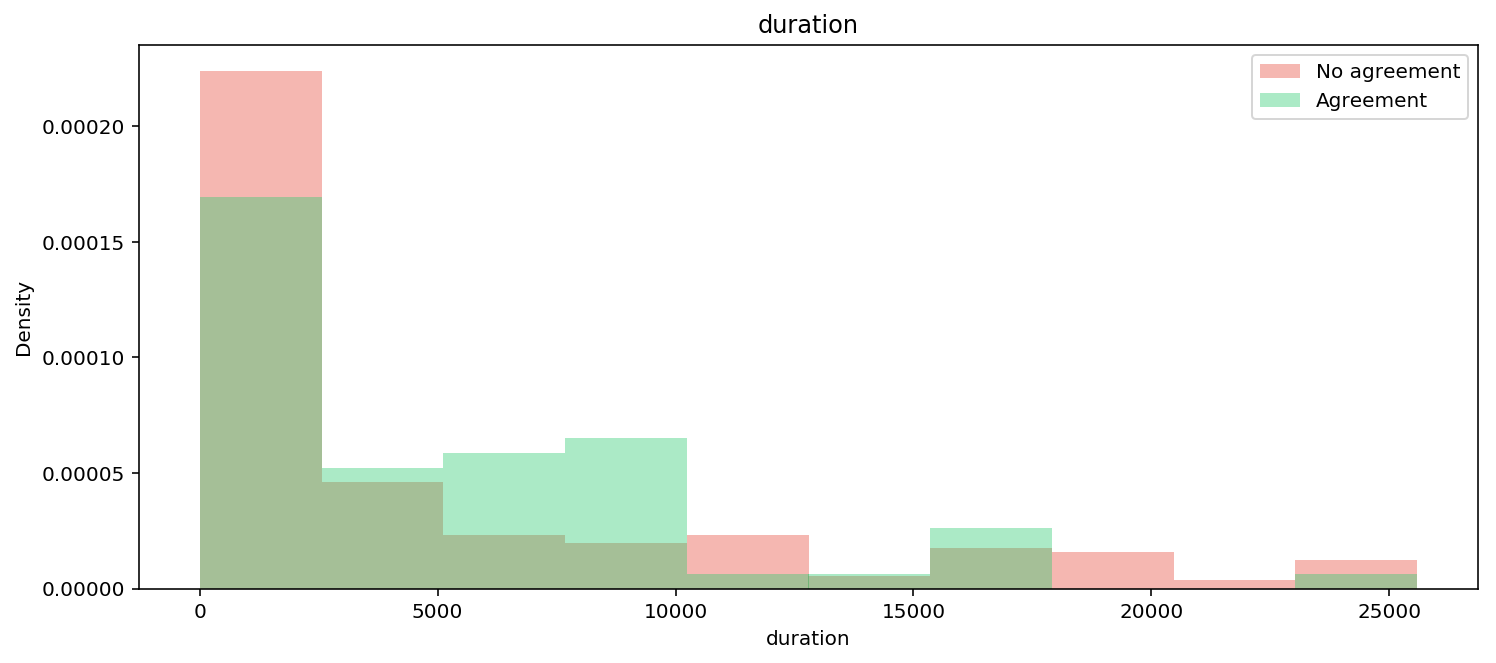

In [39]:
#plot the distrib
plt.figure(figsize=(12,5))
plot_distrib(s1=clean_df['duration'][clean_df['agreement'] == 0], s2=clean_df['duration'][clean_df['agreement'] == 1], title='duration', xLabel = 'duration', yLabel='Density', ax=None)

In [40]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(clean_df['duration'][clean_df['agreement'] == 0], clean_df['duration'][clean_df['agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.173       0.107


#### `duration` distribution

As we have the date, we can know the duration of the conflict by substracting the `enddate` and the `startdate`. The duration is given in days. 

The distribution kind of look the same across the conflicts that did or did not receive a peace agreement.

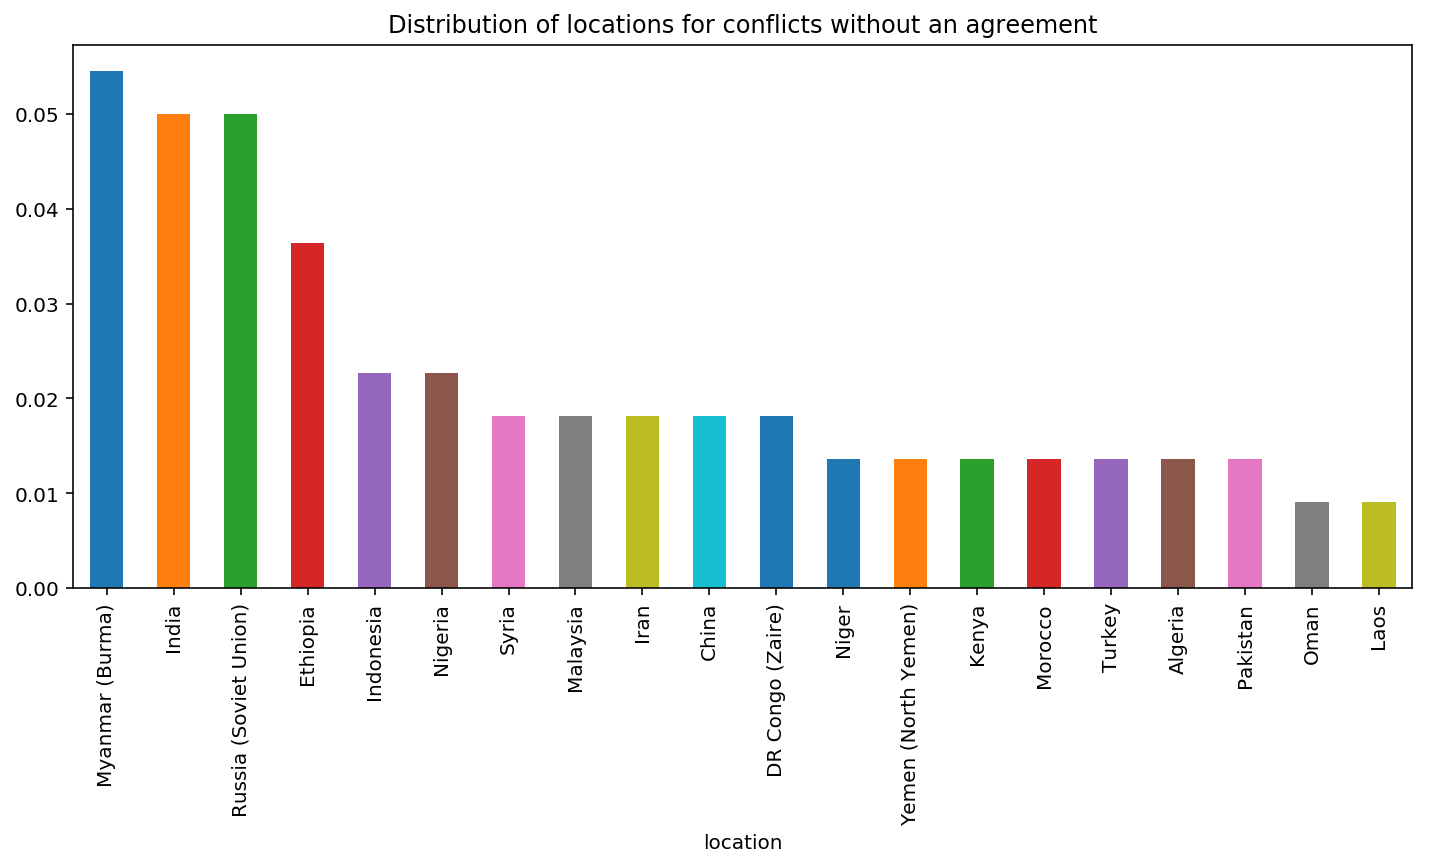

In [41]:
#Here we have to do the histogram ourselves
locationNAcount = clean_df[clean_df['agreement'] == 0].groupby('location').count()['sidea']
#Check the % for each location
locationNAcount = locationNAcount / len(clean_df[clean_df['agreement'] == 0])
locationNAcount.sort_values(ascending = False , inplace = True)
plt.figure(figsize=(12,5))
plt.title('Distribution of locations for conflicts without an agreement')
locationNAcount[:20].plot('bar')

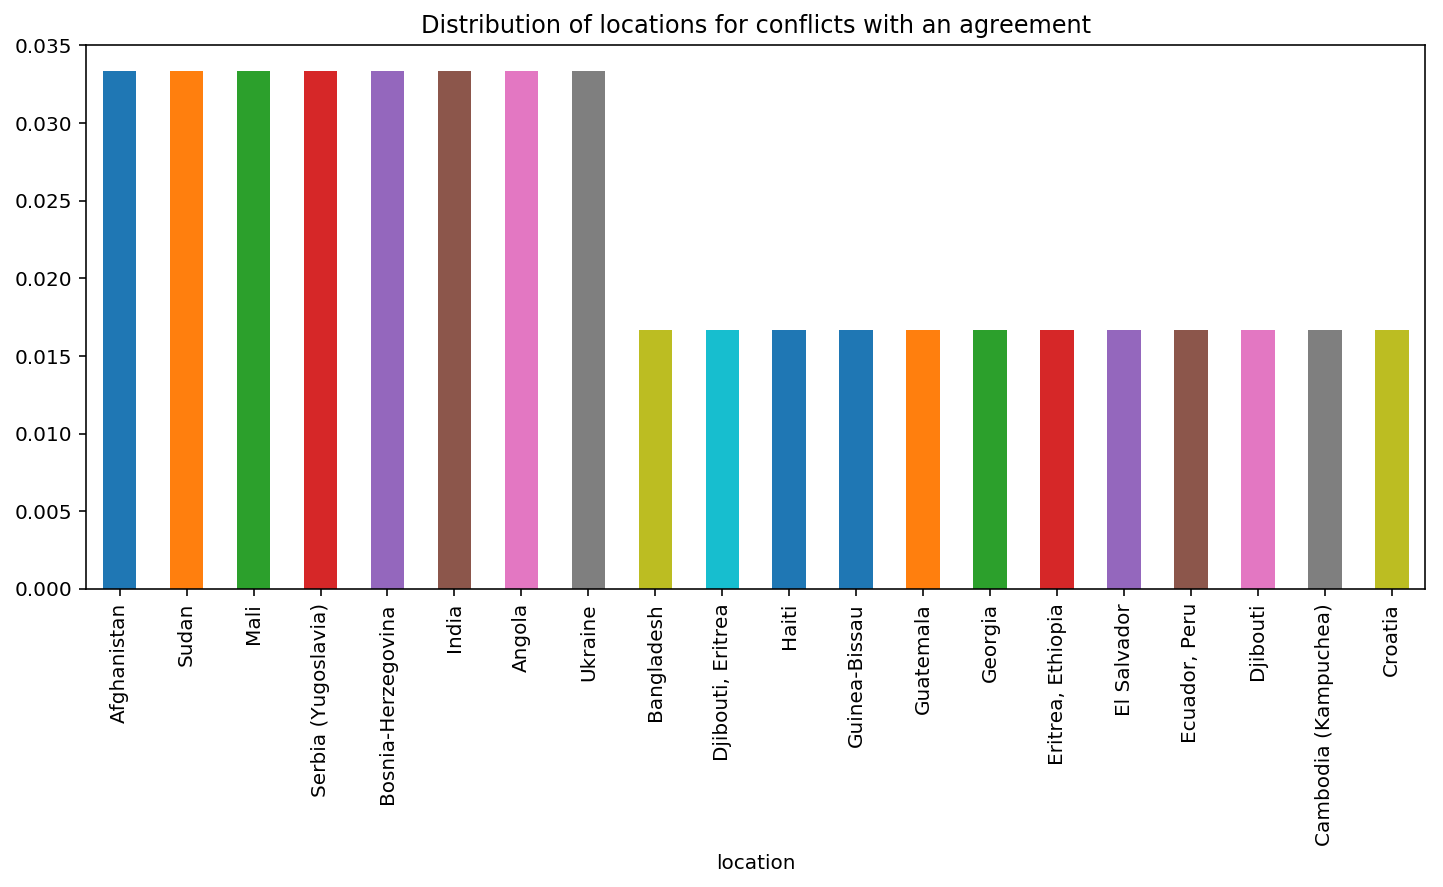

In [42]:
locationcount = clean_df[clean_df['agreement'] == 1].groupby('location').count()['sidea']
#Check the % for each location
locationcount = locationcount / len(clean_df[clean_df['agreement'] == 1])
locationcount.sort_values(ascending = False , inplace = True)
plt.figure(figsize=(12,5))
plt.title('Distribution of locations for conflicts with an agreement')
locationcount[:20].plot('bar')

#### `location` distribution

For the `location` variable the distribution looks quite different. On the other hand, this information is so different for every CID that it will be hard to use in our propensity score matching. We will prefer to check the distribution across the regions instead.

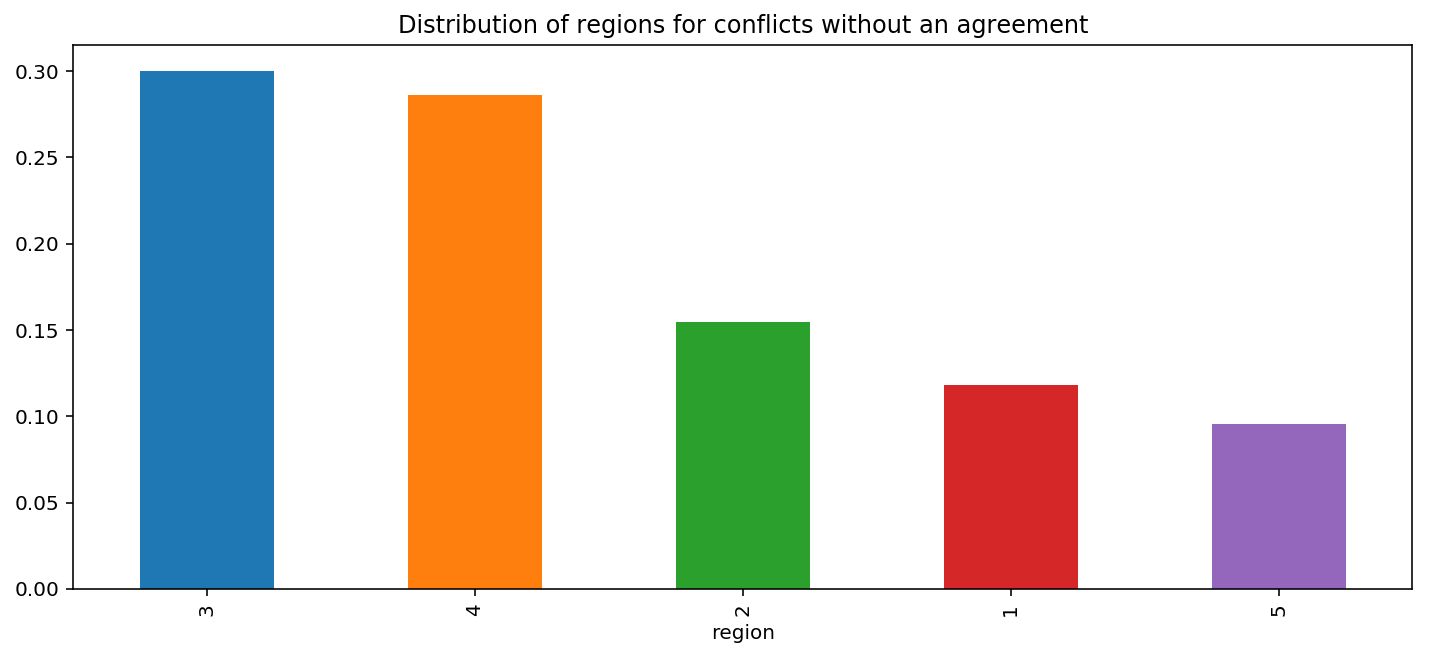

In [43]:
regionNAcount = clean_df[clean_df['agreement'] == 0].groupby('region').count()['sidea']
#Check the % for each region
regionNAcount = regionNAcount / len(clean_df[clean_df['agreement'] == 0])
regionNAcount.sort_values(ascending = False , inplace = True)
plt.figure(figsize=(12,5))
plt.title('Distribution of regions for conflicts without an agreement')
regionNAcount[:5].plot('bar')

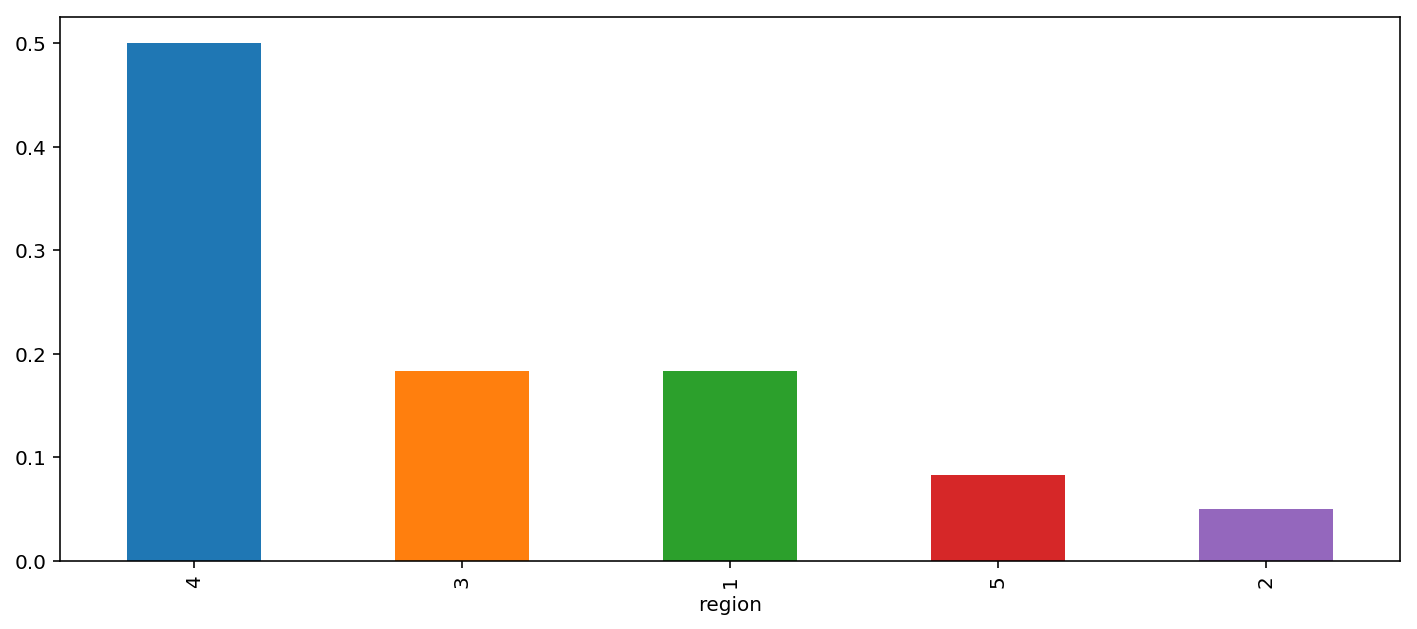

In [44]:
regioncount = clean_df[clean_df['agreement'] == 1].groupby('region').count()['sidea']
#Check the % for each region
regioncount = regioncount / len(clean_df[clean_df['agreement'] == 1])
regioncount.sort_values(ascending = False , inplace = True)
plt.figure(figsize=(12,5))
regioncount.plot('bar')

#### `region` distribution

For the `region` variable the distribution looks very different. This will have to be investigated and we will maybe force this variable to be equal in our propensity score matching.

# For the next markdown :

## Propensity score matching agreements / no agreements :

Even if the distributions across the variables looks quite the same, it will be interresting to check how a propensity score matching works on this data and then check if a peace agreement helps to bring stability in a region or not. We will have to code the later variable. We already have a few ideas on how to do that.

## Propensity score matching agreements / UN agreements : 

Then we will run the same analysis as we previously did but this time we will filter the CIDs to be distributed the same before doing another propensity score matching on the agreements so we are sure our analysis is not naive.

## Plot the map of the conflicts/ Peace Agreements